<a href="https://colab.research.google.com/github/vischia/adfm_2024-2025/blob/master/neuromorphic_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten digits

This merges tutorials from:
- https://rockpool.ai/basics/hello_MNIST.html
- https://www.tensorflow.org/quantum/tutorials/mnist

and adds a comparison between the performance of the neuromorphic, classica, and the quantum mode.

In [ ]:
############## NEUROMORPHIC
!pip install torch torchvision
!pip install rockpool tonic tqdm seaborn


In [152]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

# Neuromorphic
import torch
from torch.optim.adam import Adam
import torch.nn as nn  
import torch.optim as optim 
import torch.nn.functional as F 
import torchvision

from tqdm.autonotebook import tqdm, trange
import seaborn as sns

from IPython.display import Image

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

print("Using device", device)

Using device mps


# Neuromorphic

In [153]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

from tqdm.autonotebook import tqdm, trange

from IPython.display import Image

# Leaky integrate-and-fire

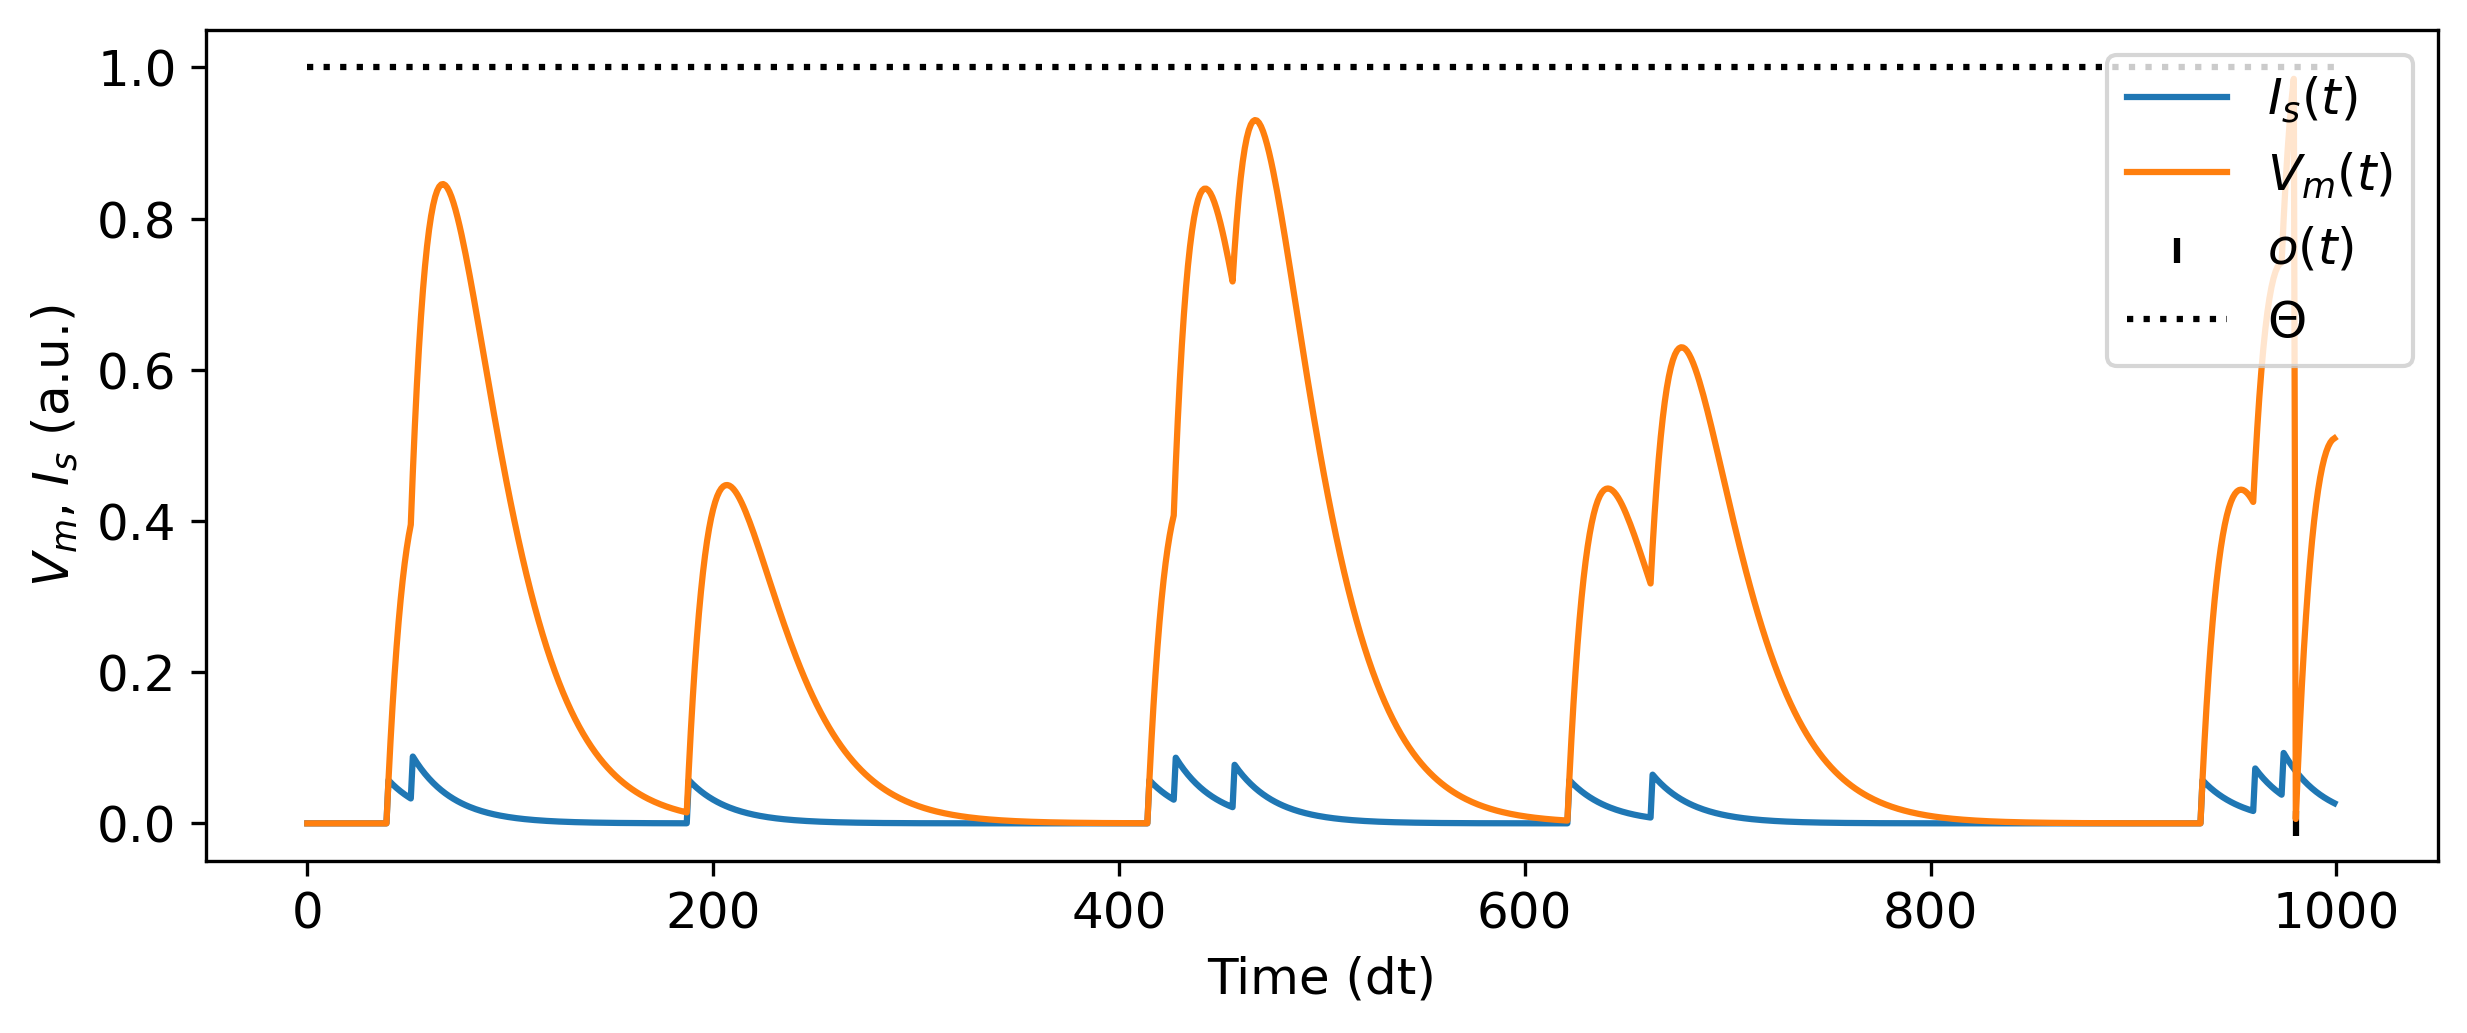

In [172]:
# - Import the SNN modules from rockpool
from rockpool.nn.modules import LIF
import numpy as np
# - Generate a spiking neuron
neuron = LIF(1)

# - Simulate this neuron for 1 sec with poisson spiking input z(t)
num_timesteps = int(1/neuron.dt)
input_z = 0.06 * (np.random.rand(num_timesteps) < 0.0125)
output, _, rec_dict = neuron(input_z, record = True)

# - Display the input, internal state and output events
plt.figure()
plt.plot(rec_dict['isyn'].squeeze(), label = '$I_s(t)$')
plt.plot(rec_dict['vmem'].squeeze(), label = '$V_m(t)$')
b, t, n = np.nonzero(output)
plt.scatter(t, n, marker='|', c = 'k', label = '$o(t)$')
plt.plot([0, num_timesteps], [neuron.threshold] * 2, 'k:', label='$\\Theta$')
plt.xlabel('Time (dt)')
plt.ylabel('$V_m$, $I_s$ (a.u.)')
plt.legend();


# Again, load MNIST

But now we need also to encode the data in a SNN-compliant way


In [155]:
# - Number of samples per batch
batch_size = 256

# - Download and access the MNIST training dataset
train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
test_data = torchvision.datasets.MNIST(
    root=".",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
evens = list(range(0, len(train_data), 100))
evenst = list(range(0, len(test_data), 100))
# - Create a data loader for the training dataset
train_subdata = torch.utils.data.Subset(train_data, evens)
test_subdata = torch.utils.data.Subset(test_data, evens)

train_loader = torch.utils.data.DataLoader(
    train_subdata,
    batch_size=batch_size, shuffle=True
)

# - Create a test dataset
test_loader = torch.utils.data.DataLoader(
    test_subdata,
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=torchvision.transforms.ToTensor(),
    ),
    batch_size=batch_size,
)

Now we need to decide how to encode the data samples for the SNN. The MNIST samples are resolution images, with no temporal component. We will encode the images by arranging the pixels into a 784-element vector, and creating 784 spiking input channels. We’ll use a Poisson process to generate an average input rate for each channel, according to the intensity of the corresponding pixel. Pixels with value 0 will have generate no input events; pixels with value 1 will generate the highest rate of events. To do so we need to define how many time-steps each sample will take, and what the duration of a single time-step will be.

In [156]:
# - Define the temporal aspects of a data sample
num_timesteps = 100
dt = 10e-3

# - Extract the number of classes and input channels
num_classes = len(torchvision.datasets.MNIST.classes)
input_channels = train_data[0][0].numel()

# - Define a function to encode an input into a poisson event series
def encode_poisson(data: torch.Tensor, num_timesteps: int, scale: float = 0.1) -> torch.Tensor:
  num_batches, frame_x, frame_y = data.shape
  data = scale * data.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1))
  return (torch.rand(data.shape) < (data * scale)).float()

We also need to determine what the target output of the network will look like. The MNIST dataset has 10 classes. We’ll build a network with 10 output neurons, one for each class, and train the network to produce a high event rate for the target class and no events for the non-target classes. Our target will also be a time series of events, with the same duration as the input time series, and with 10 channels.

In [157]:
# - Define a function to encode the network target
def encode_class(class_idx: torch.Tensor, num_classes: int, num_timesteps: int) -> torch.Tensor:
  num_batches = class_idx.numel()
  target = torch.nn.functional.one_hot(class_idx, num_classes = num_classes)
  return target.view((num_batches, 1, -1)).repeat((1, num_timesteps, 1)).float()


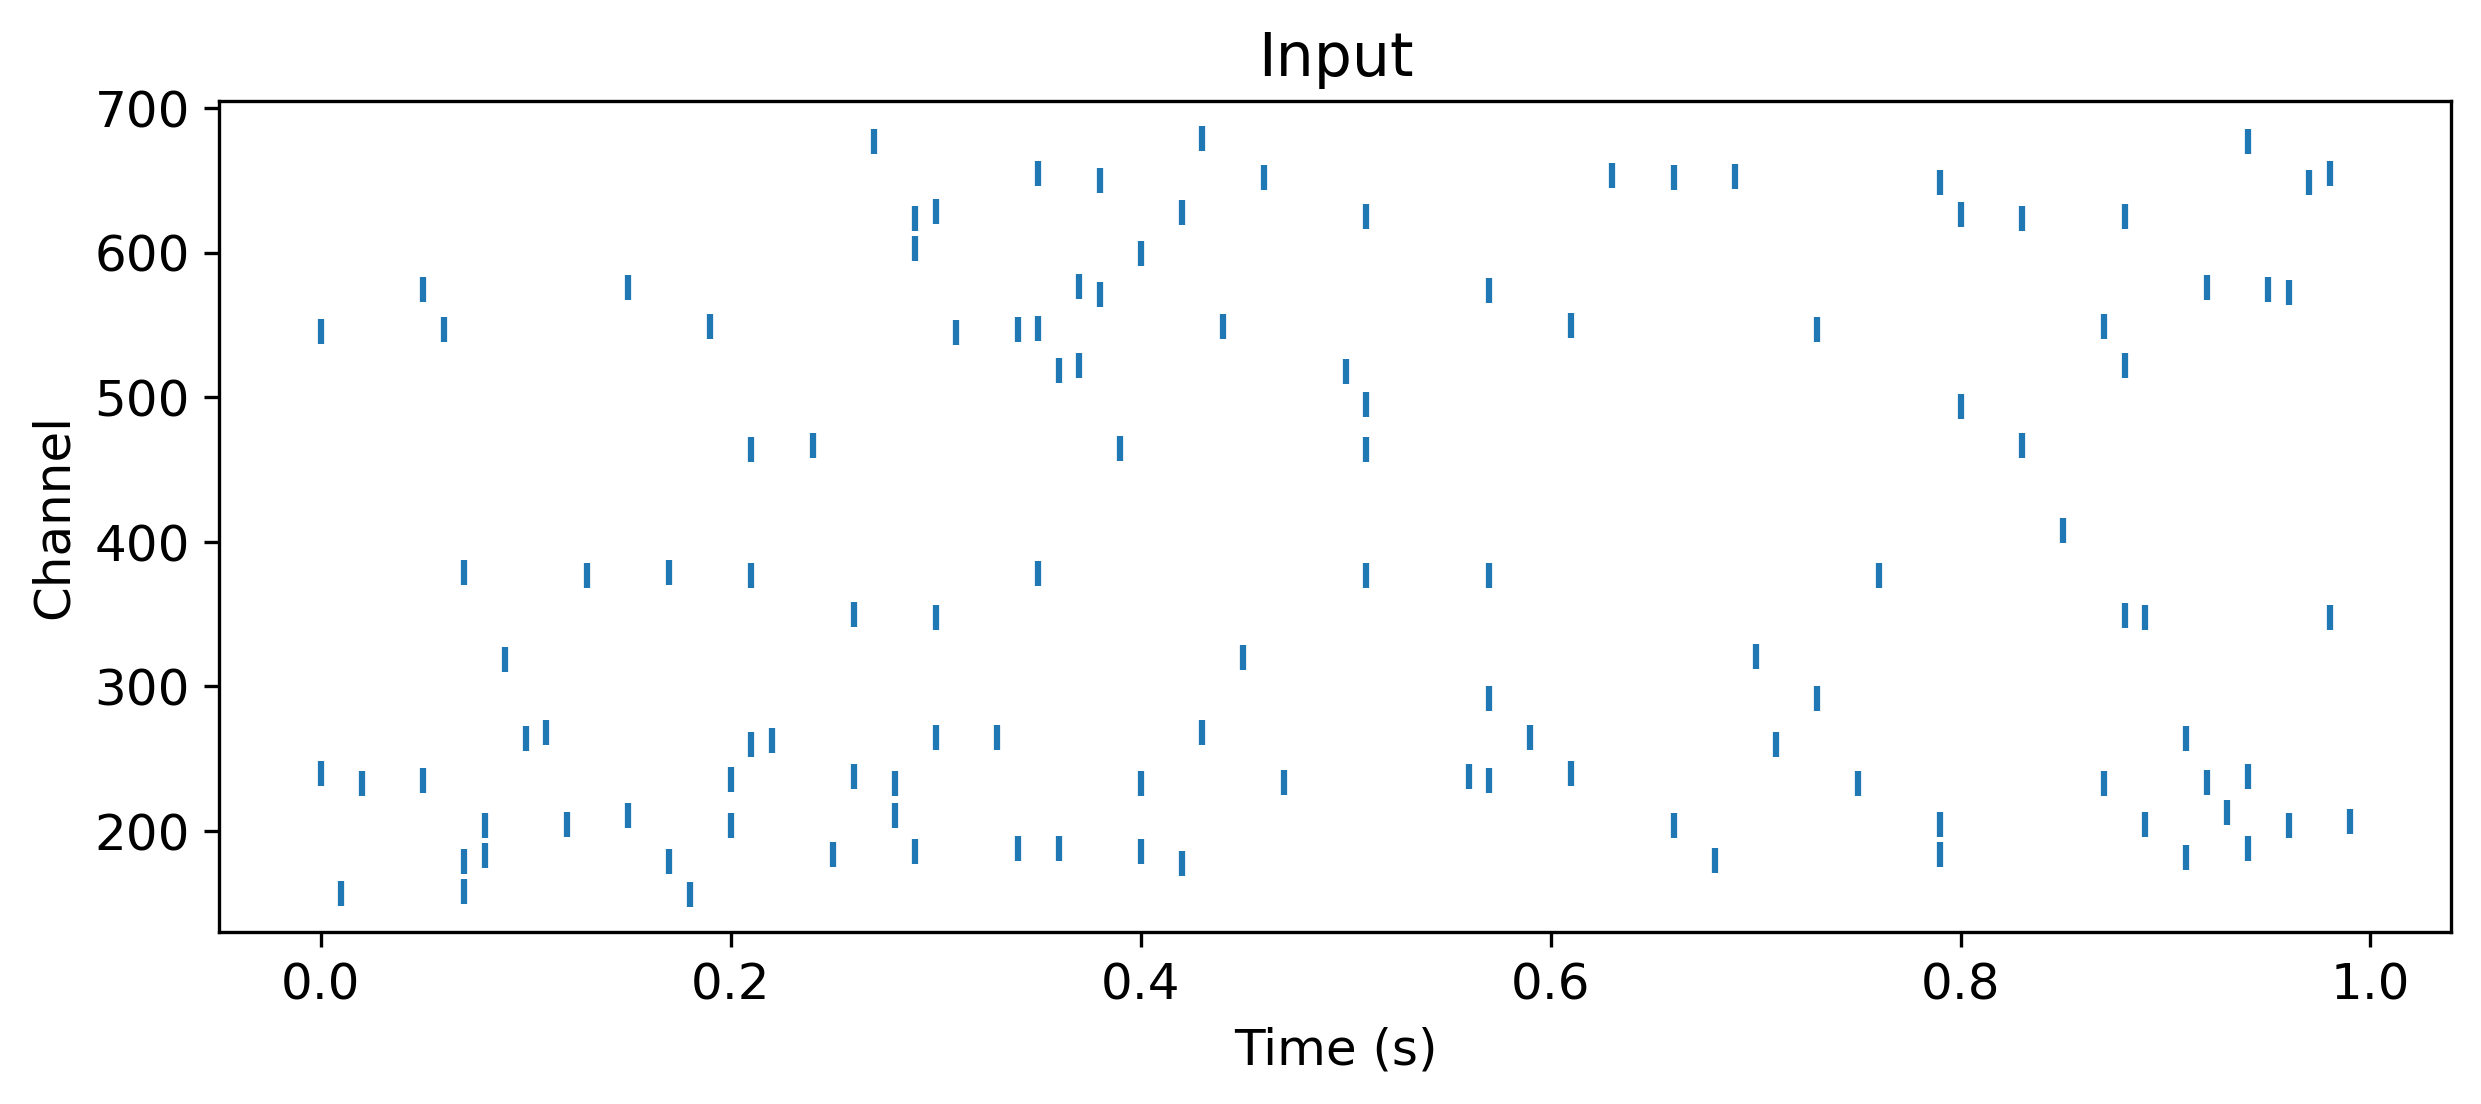

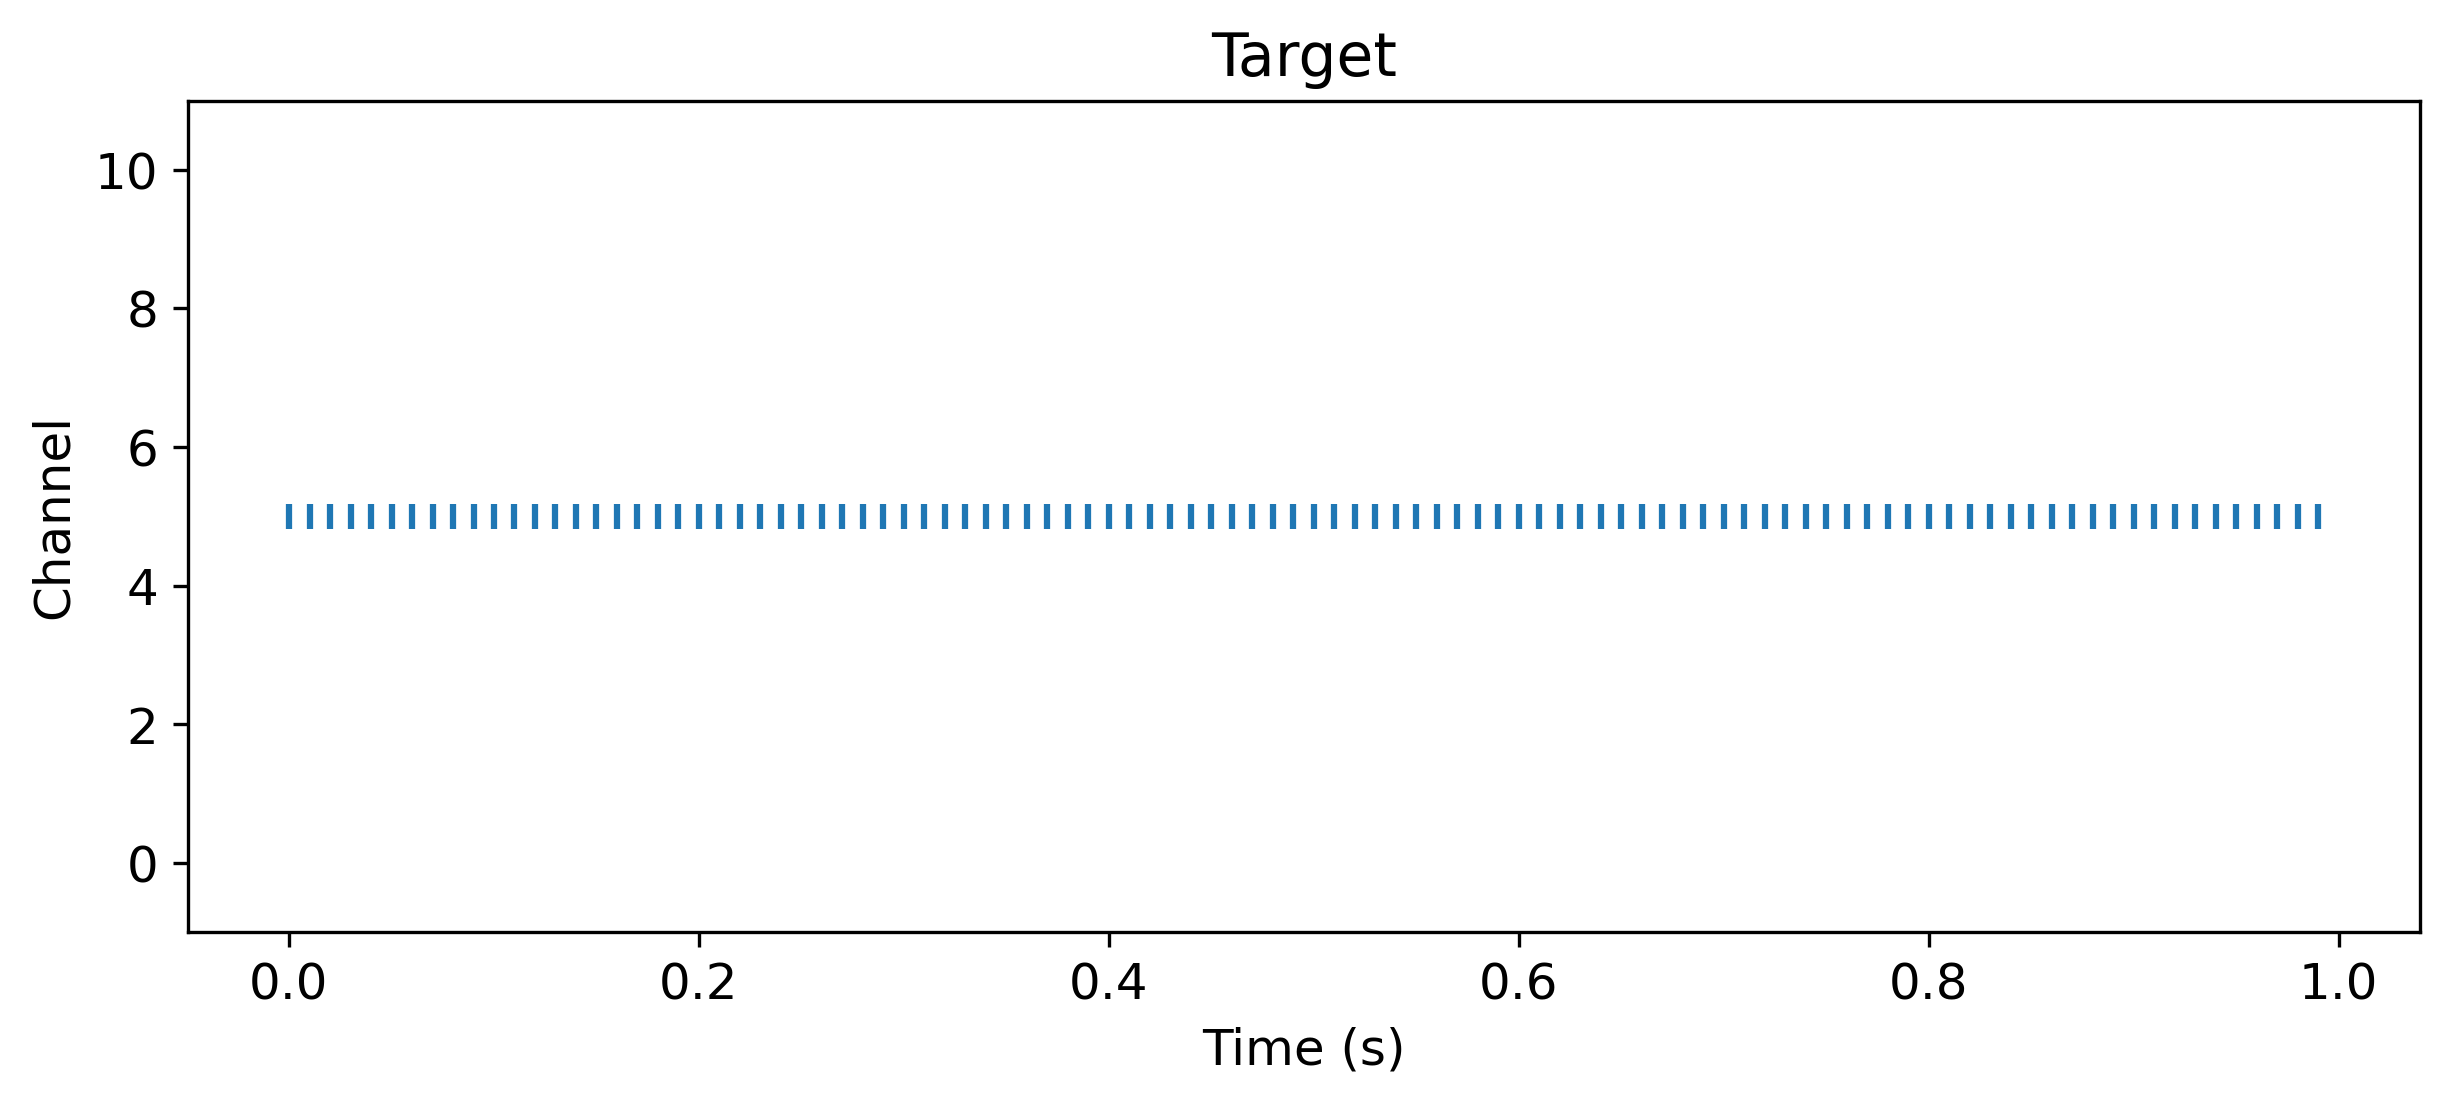

In [158]:
# - Get one sample
frame, class_idx = train_data[0]

# - Encode the input and targets
data = encode_poisson(frame, num_timesteps)
target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

# - Plot the poisson input for this sample
plt.figure()
b, t, n = torch.nonzero(data, as_tuple = True)
plt.scatter(t * dt, n, marker = '|')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Input')

# - Plot the target event series for this sample
b, t, n = torch.nonzero(target, as_tuple = True)
plt.figure()
plt.scatter(t * dt, n, marker = '|')
plt.ylim([-1, num_classes+1])
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Target');




Rockpool allows you to build SNNs with a simple syntax, similar to PyTorch. We support several computational back-ends in Rockpool, one of which is PyTorch, which we will use here.

LIFTorch is a Rockpool and torch module which provides a trainable simulation of LIF spiking neurons. LinearTorch is a linear weight matrix, comparable to the torch nn.Linear module.

To build simple feed-forward networks, we use the Sequential combinator from Rockpool, which functions like the torch nn.Sequential combinator.

By default, Rockpool allows you to train the time constants

and other parameters of an SNN. For simplicity, here we’ll define them as constant (i.e. non-trainable), using the Constant parameter decorator.

The network architecture we will use is shown below; a simple two-layer SNN.

![](https://www.hep.uniovi.es/vischia/persistent/figures/basics_hello_MNIST_14_0.png)

In [159]:
# - Import network packages
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Define a simple network
num_hidden_1 = 128
num_hidden_2 = 64
tau_mem = Constant(100e-3)
tau_syn = Constant(50e-3)
threshold = Constant(1.)
bias = Constant(0.)

# - Define a two-layer feed-forward SNN
snn = Sequential(
    LinearTorch((input_channels, num_hidden_1)),
    LIFTorch(num_hidden_1, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt),
    LinearTorch((num_hidden_1, num_hidden_2)),
    LIFTorch(num_hidden_2, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt),
    LinearTorch((num_hidden_2, num_classes)),
    LIFTorch(num_classes, tau_syn = tau_syn, tau_mem = tau_mem, threshold = threshold, bias = bias, dt = dt)
)
print(snn)

TorchSequential  with shape (784, 10) {
    LinearTorch '0_LinearTorch' with shape (784, 128)
    LIFTorch '1_LIFTorch' with shape (128, 128)
    LinearTorch '2_LinearTorch' with shape (128, 64)
    LIFTorch '3_LIFTorch' with shape (64, 64)
    LinearTorch '4_LinearTorch' with shape (64, 10)
    LIFTorch '5_LIFTorch' with shape (10, 10)
}


# Untrained SNN

Let’s examine the un-trained output of this network. We simulate the network identically as with the single LIF neuron above, just by passing input data to the module. We’ll use the single data sample we encoded above. The record = True argument tells Rockpool to record all the internal state of the SNN during evolution.


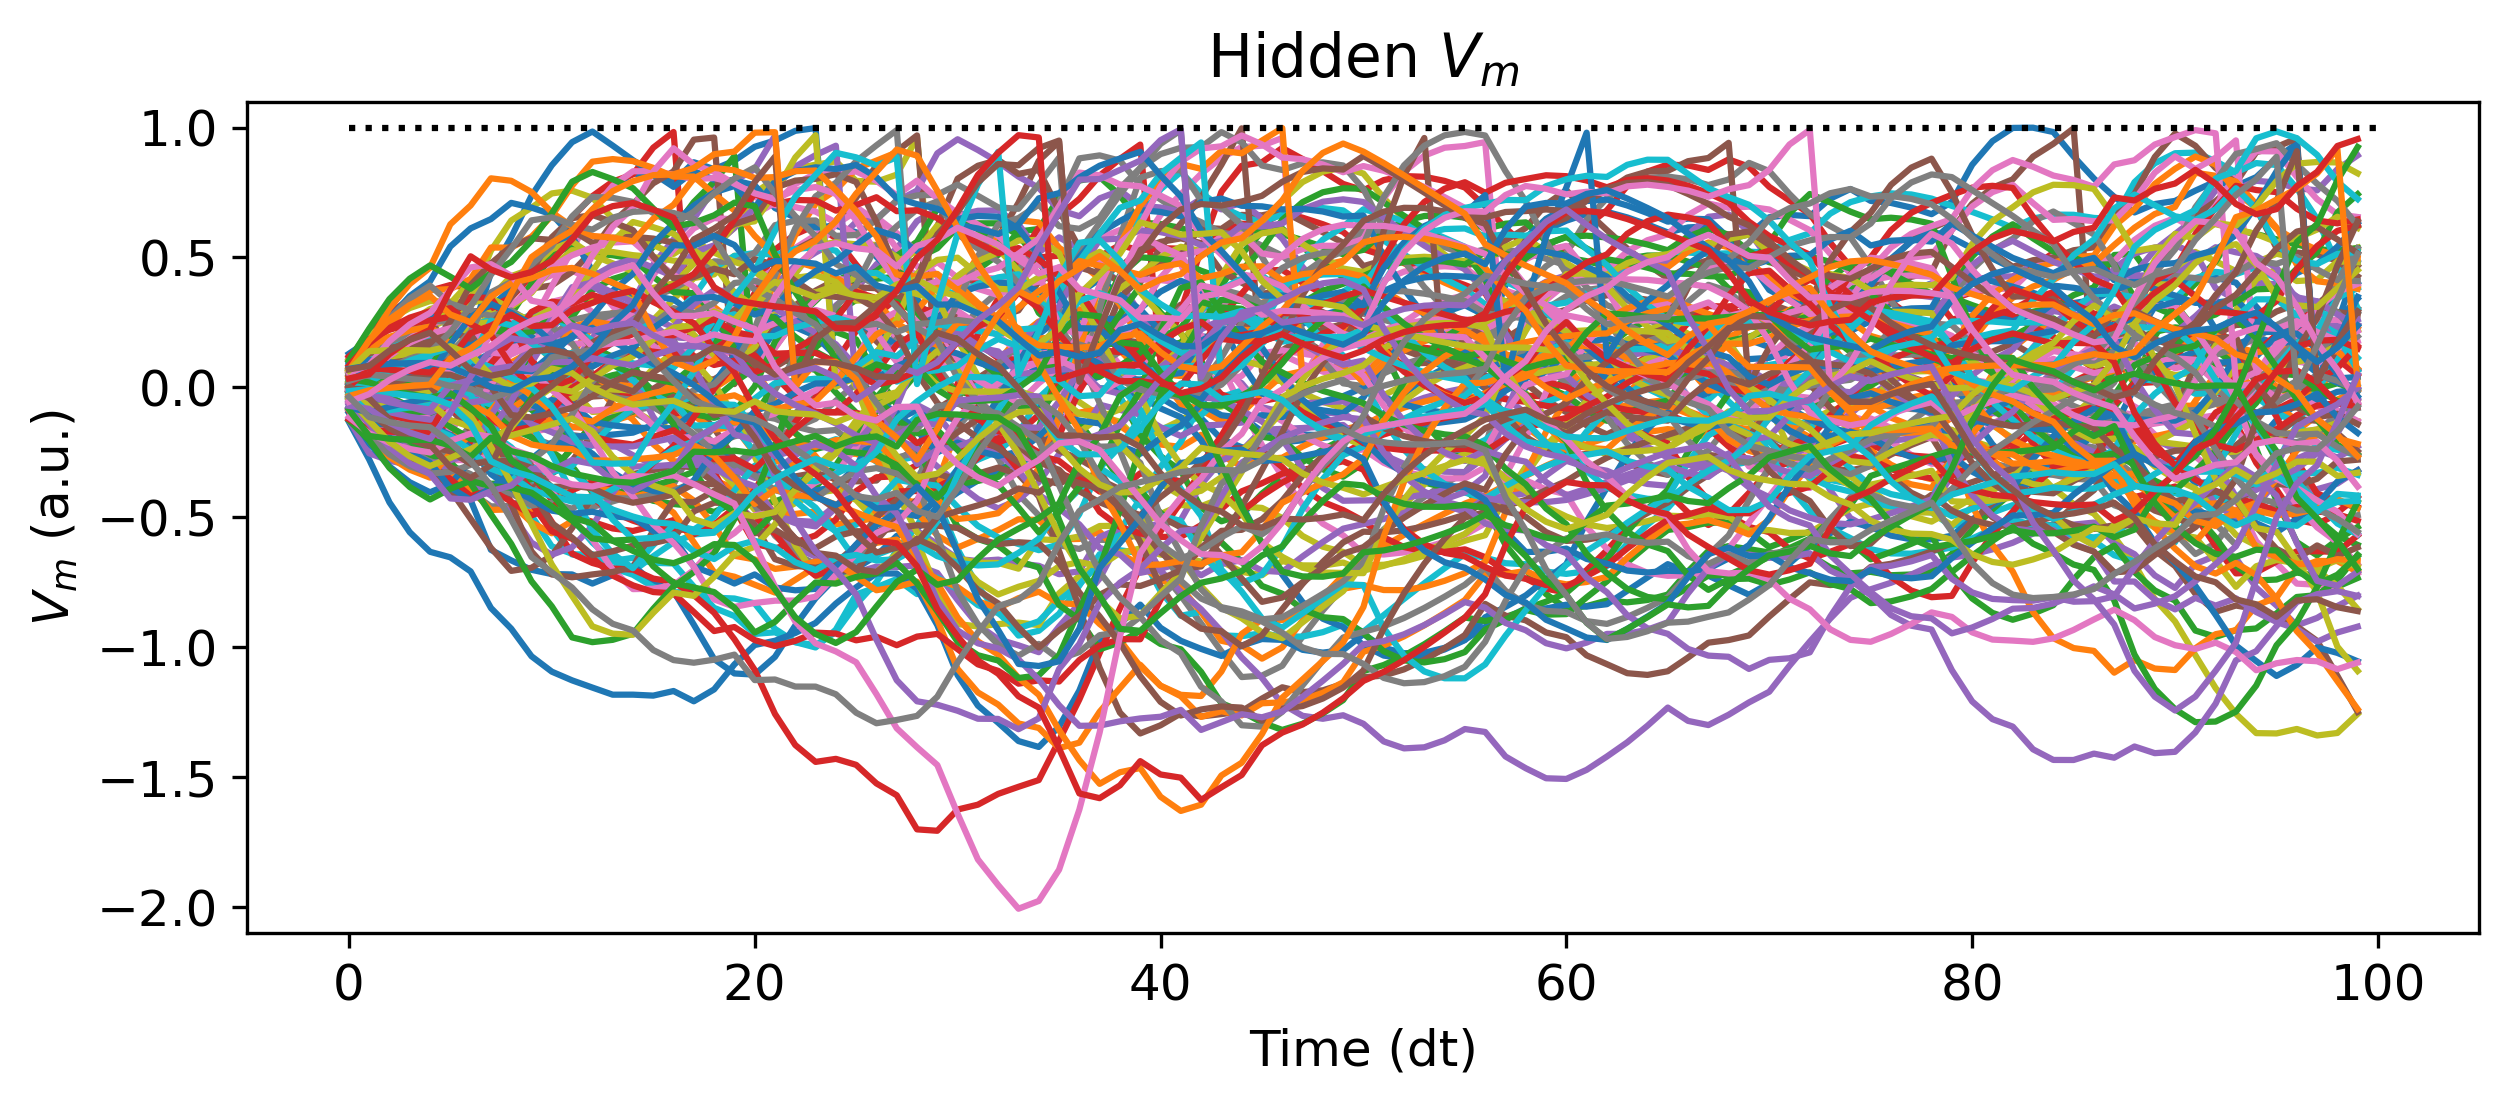

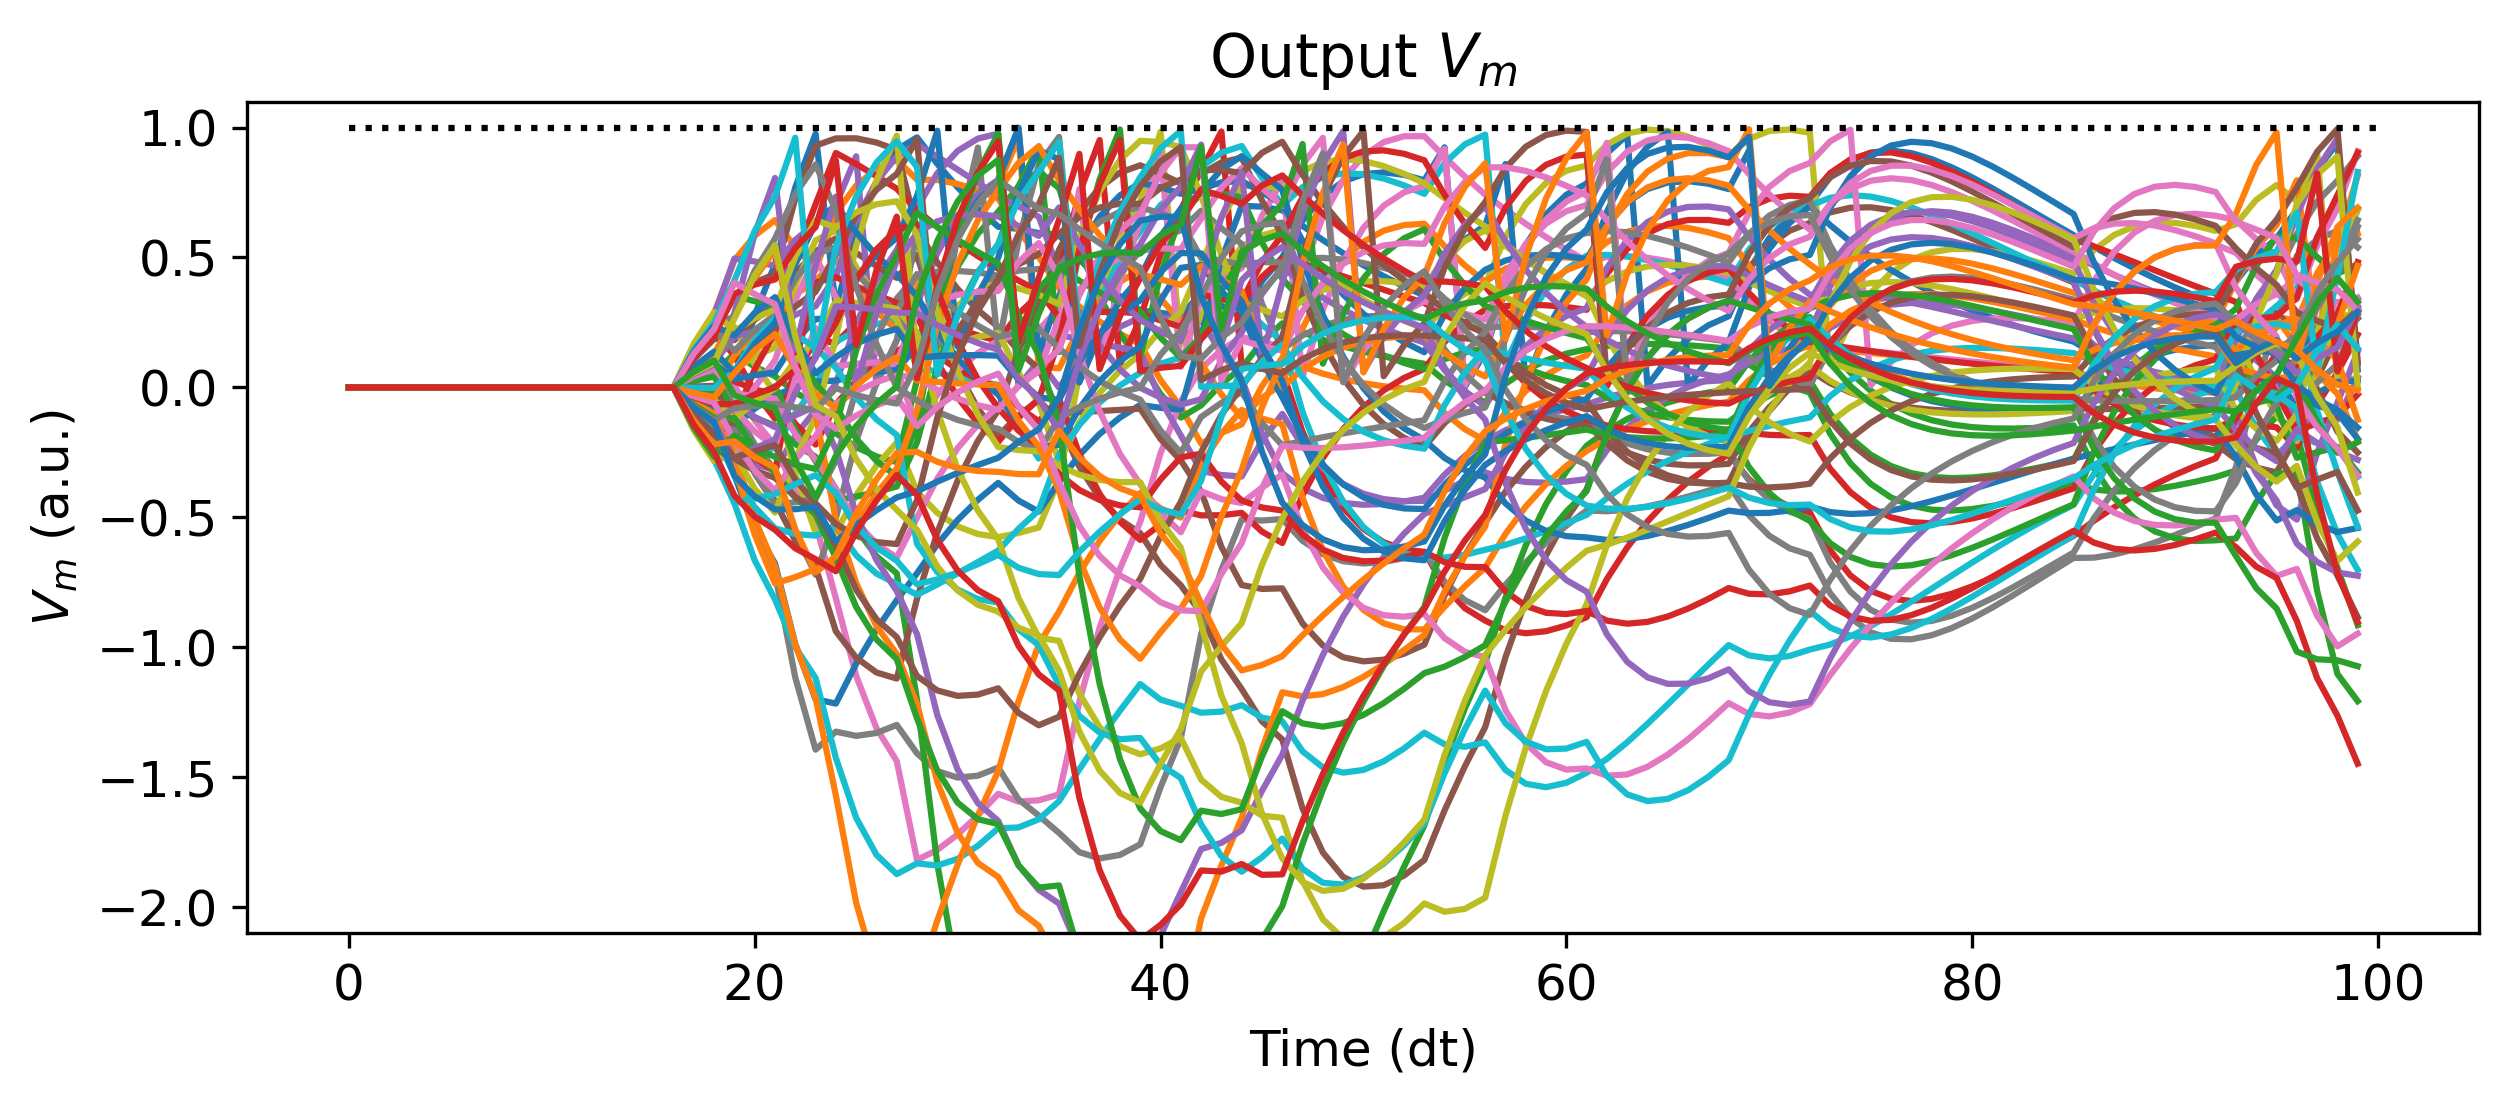

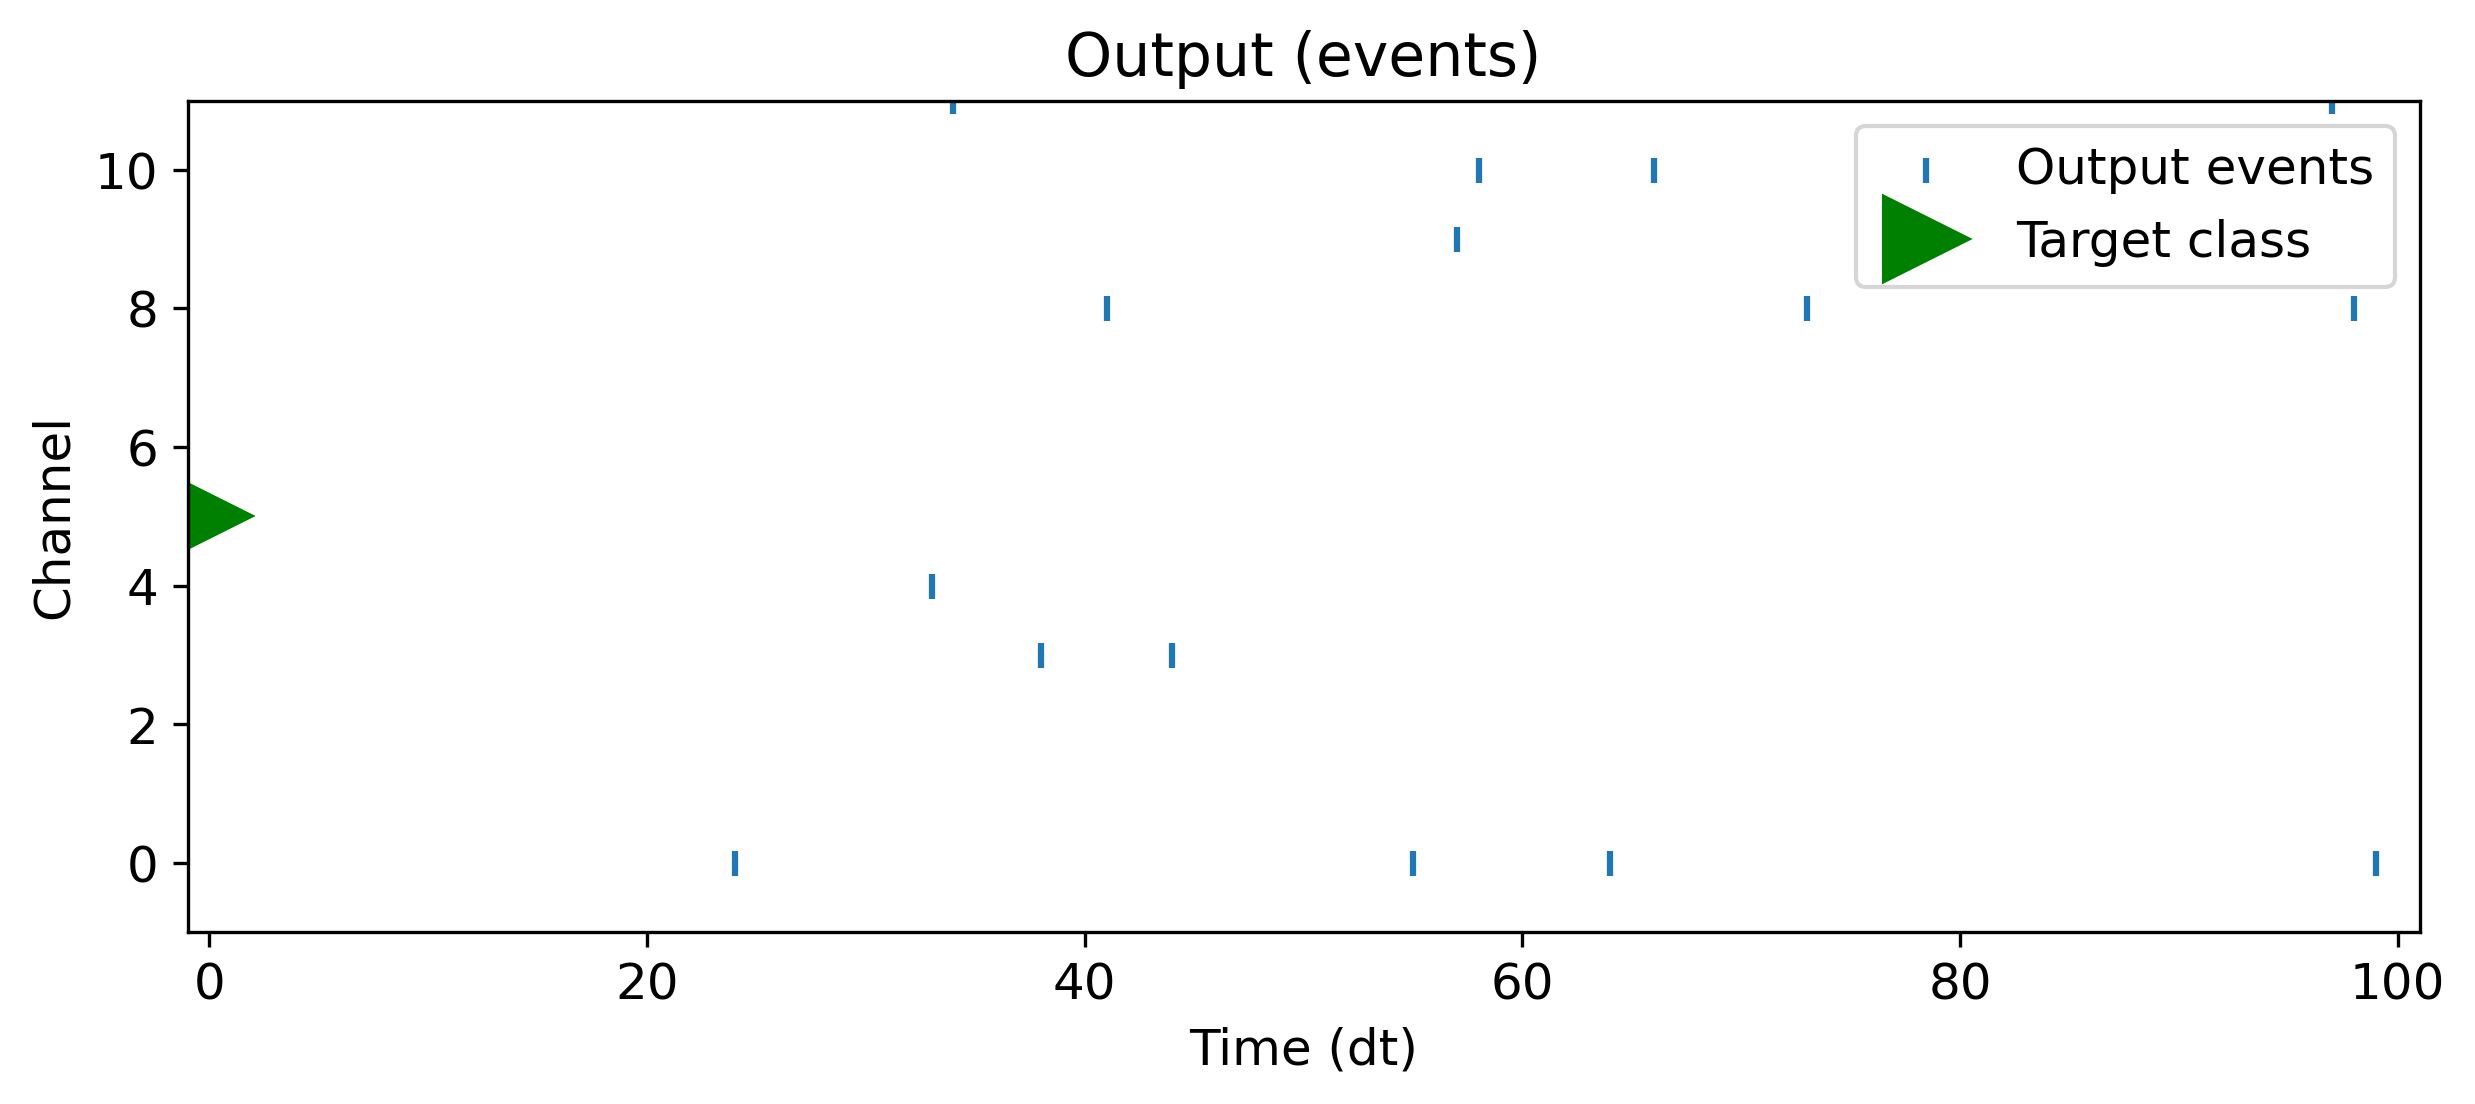

In [160]:
# - Simulate the untrained network, record internal state
output, _, rec_dict = snn(data, record = True)

# - Display the internal state and output
plt.plot(rec_dict['1_LIFTorch']['vmem'][0].detach());
plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
plt.ylim([-2.1, 1.1])
plt.xlabel('Time (dt)')
plt.ylabel('$V_m$ (a.u.)')
plt.title('Hidden $V_m$')

plt.figure()
plt.plot(rec_dict['3_LIFTorch']['vmem'][0].detach());
plt.plot([0, num_timesteps], [threshold] * 2, 'k:')
plt.ylim([-2.1, 1.1])
plt.xlabel('Time (dt)')
plt.ylabel('$V_m$ (a.u.)')
plt.title('Output $V_m$')

plt.figure()
t, n = torch.nonzero(rec_dict['3_LIFTorch_output'][0].detach(), as_tuple = True)
plt.scatter(t, n, marker = '|', label='Output events')
plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
plt.ylim([-1, num_classes+1])
plt.xlim([-1, num_timesteps+1])
plt.xlabel('Time (dt)')
plt.ylabel('Channel')
plt.title('Output (events)')
plt.legend();



In [161]:
# - Initialise the optimizer with the network parameters
lr = 0.1
optimizer = optim.Adam(snn.parameters().astorch(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [162]:
def neuromorphic_train(model, device, train_loader, optimizer, scheduler):
    # - Prepare model for training
    model.train()
    losses = []

    # - Loop over the dataset for this epoch
    for data, class_idx in tqdm(train_loader, leave=False, desc='Training', unit='batch'):
        # - Encode input and target
        data = encode_poisson(data.squeeze(), num_timesteps)
        target = encode_class(class_idx, num_classes, num_timesteps)

        # - Zero gradients, simulate model
        optimizer.zero_grad()
        output, _, _ = model(data.to(device))

        # - Compute MSE loss and perform backward pass
        loss = torch.nn.functional.mse_loss(output, target.to(device))
        loss.backward()
        optimizer.step()
        # - Keep track of the losses
        losses.append(loss.item())

    scheduler.step()
    return np.mean(losses)

In [163]:
def neuromorphic_test(model, device, test_loader):
    # - Prepare model for evaluation
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
      # - Loop over the dataset
      for data, class_idx in tqdm(test_loader, desc='Testing', leave=False, unit='batch'):
        # - Encode the input and target
        input = encode_poisson(data.squeeze(), num_timesteps)
        target = encode_class(class_idx, num_classes, num_timesteps)

        # - Evaluate the model
        output, _, _ = model(input.to(device))

        # - Compute loss and prediction
        losses.append(torch.nn.functional.mse_loss(output, target.to(device)).item())
        pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()
        correct += pred.eq(class_idx.view_as(pred)).sum().item()

    #test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return np.mean(losses), accuracy

In [164]:
# - Initial loss and accuracy
test_loss, test_acc = neuromorphic_test(snn.to(device), device, test_loader)
print(f'Initial test loss {test_loss}, accuracy {test_acc}%')

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Initial test loss 0.1327260799705982, accuracy 9.85%


In [165]:
# - Train some epochs
num_epochs = 50

train_losses = []
test_losses = []
test_accs = []
ep_loop = trange(num_epochs, desc='Training', unit='epoch')
for epoch in ep_loop:
    ep_loop.set_postfix(test_loss = test_loss, test_acc = f'{test_acc}%')
    losses = neuromorphic_train(snn.to(device), device, train_loader, optimizer, scheduler)
    train_losses.append(losses)
  
    # - Get test loss and accuracy
    test_loss, test_acc = neuromorphic_test(snn.to(device), device, test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)


Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Training:   0%|          | 0/3 [00:00<?, ?batch/s]

Testing:   0%|          | 0/40 [00:00<?, ?batch/s]

Text(0.5, 1.0, 'Accuracy on the test dataset')

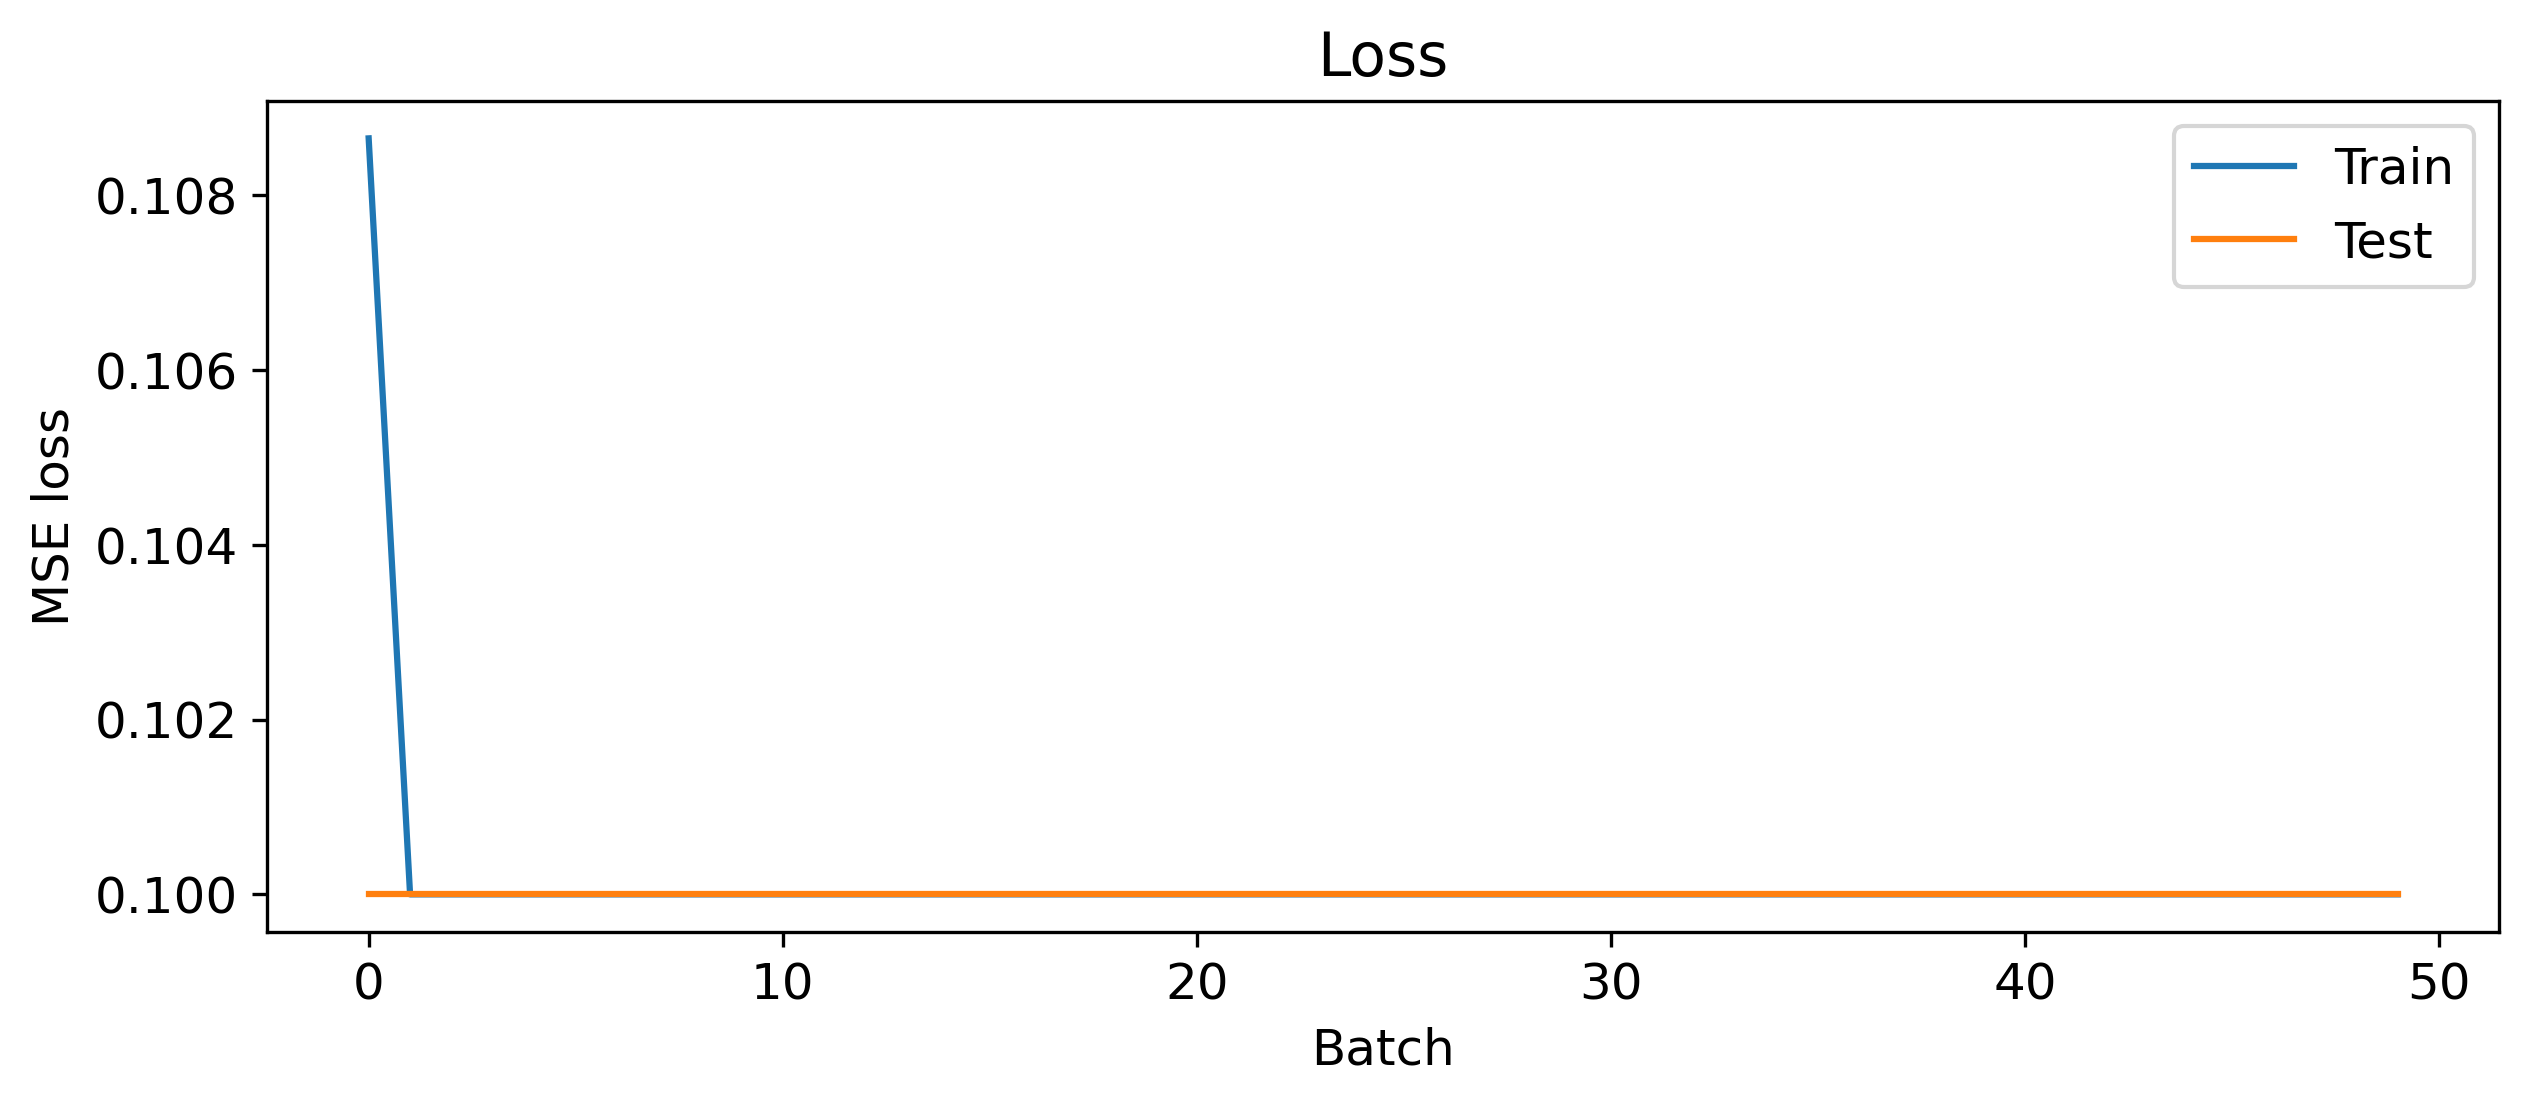

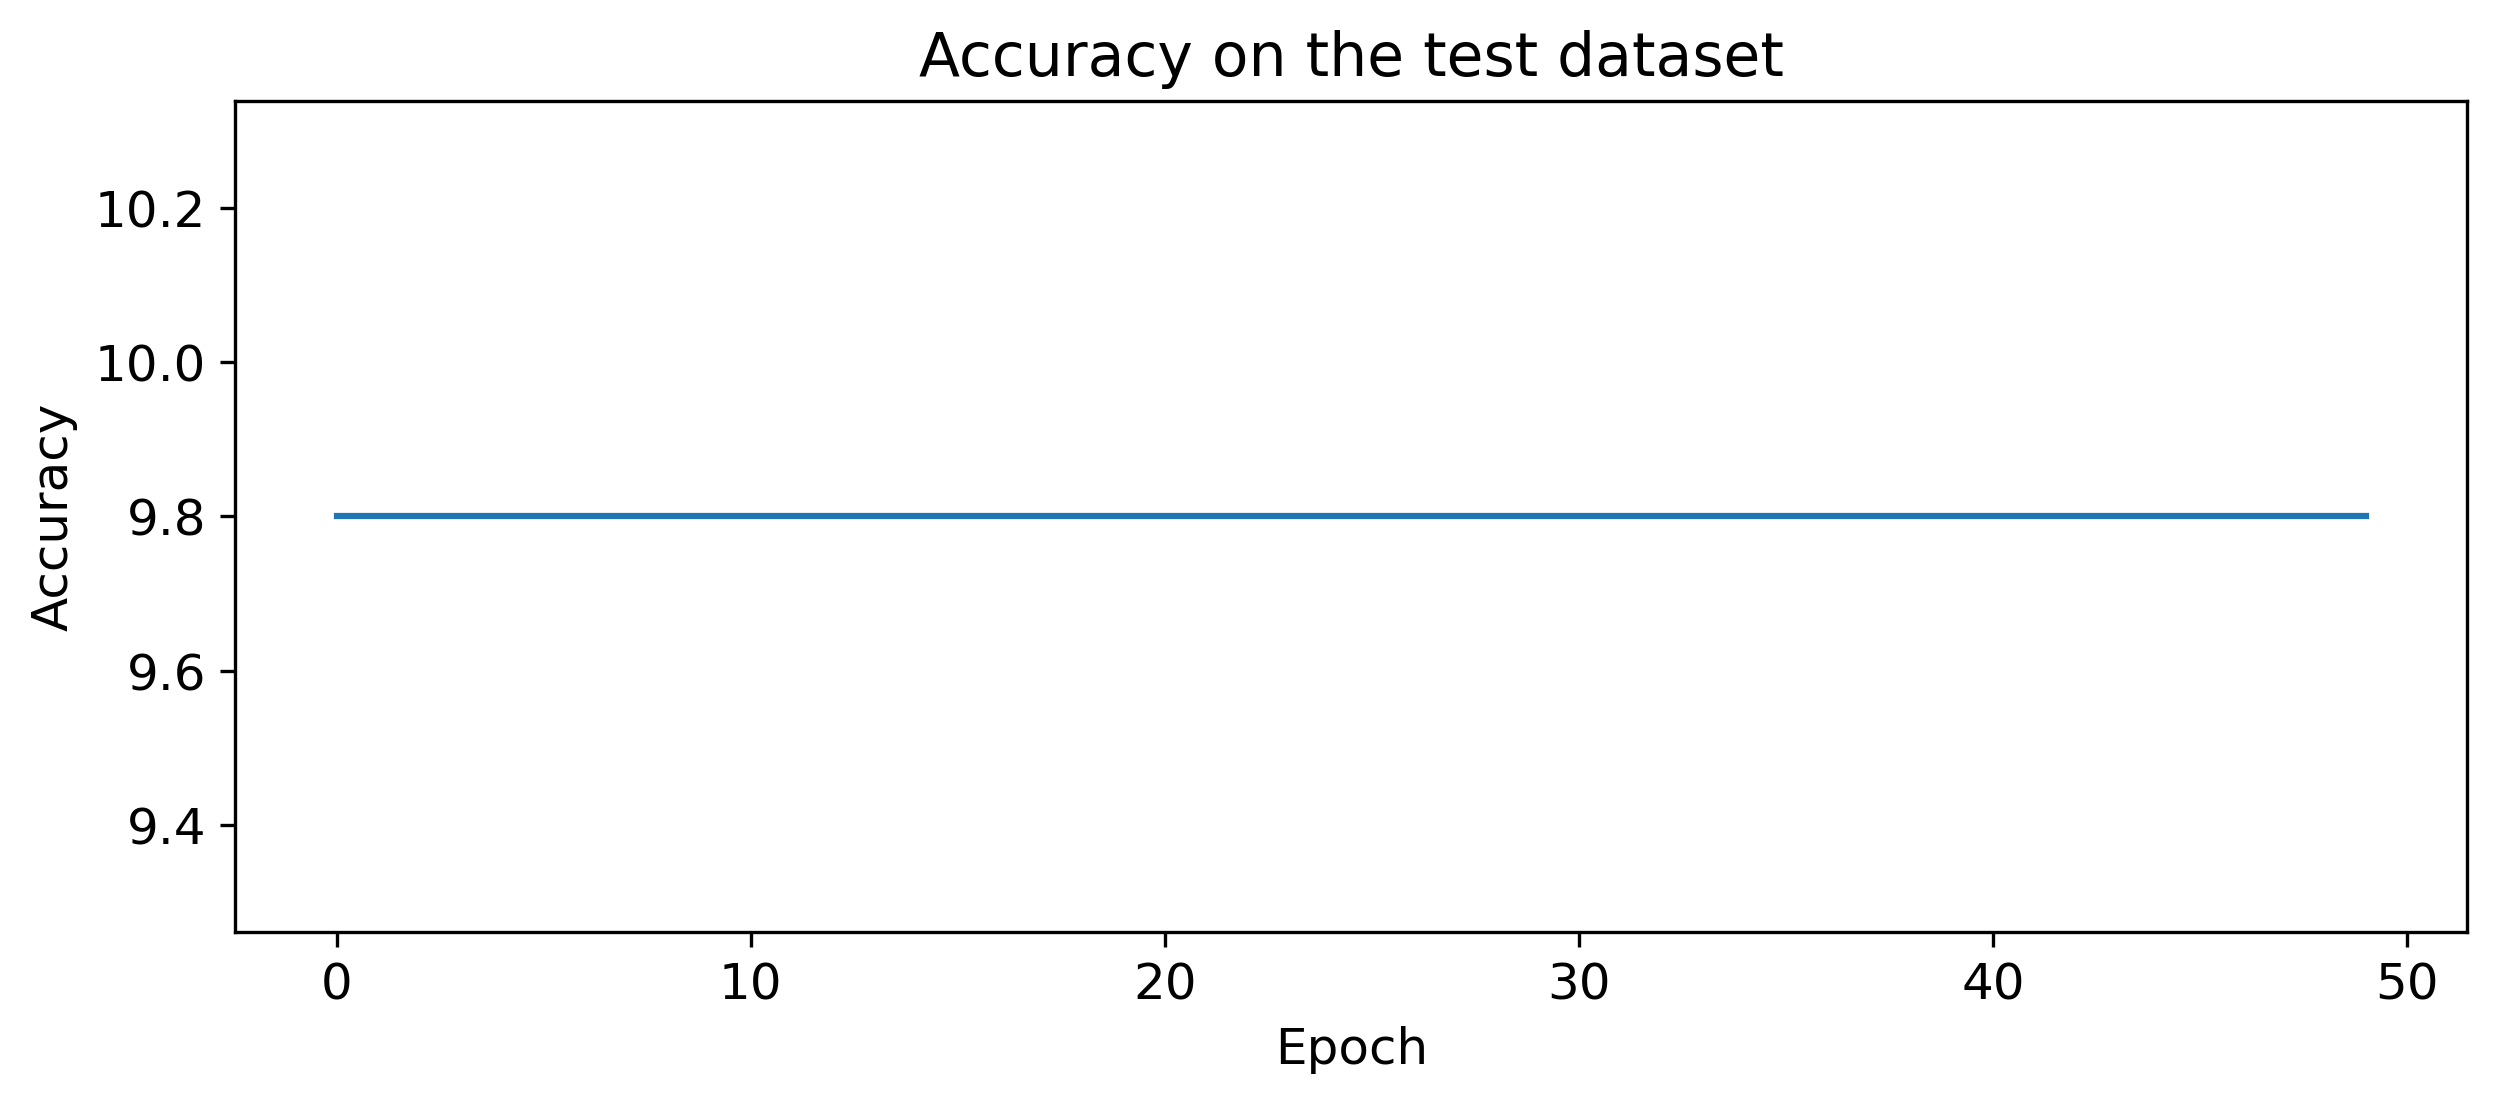

In [173]:
plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.xlabel('Batch')
plt.ylabel('MSE loss')
plt.legend(loc='best')
plt.title('Loss');

plt.figure()
plt.plot(test_accs, label="Test accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy on the test dataset')

In [174]:
# - Trained loss and accuracy
print(f'Final test loss {test_loss}, accuracy {test_acc}%')
neuro_accuracy = test_acc

Final test loss 0.10000000149011612, accuracy 9.8%


On a single image

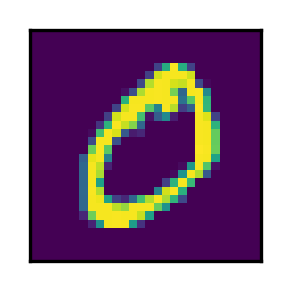

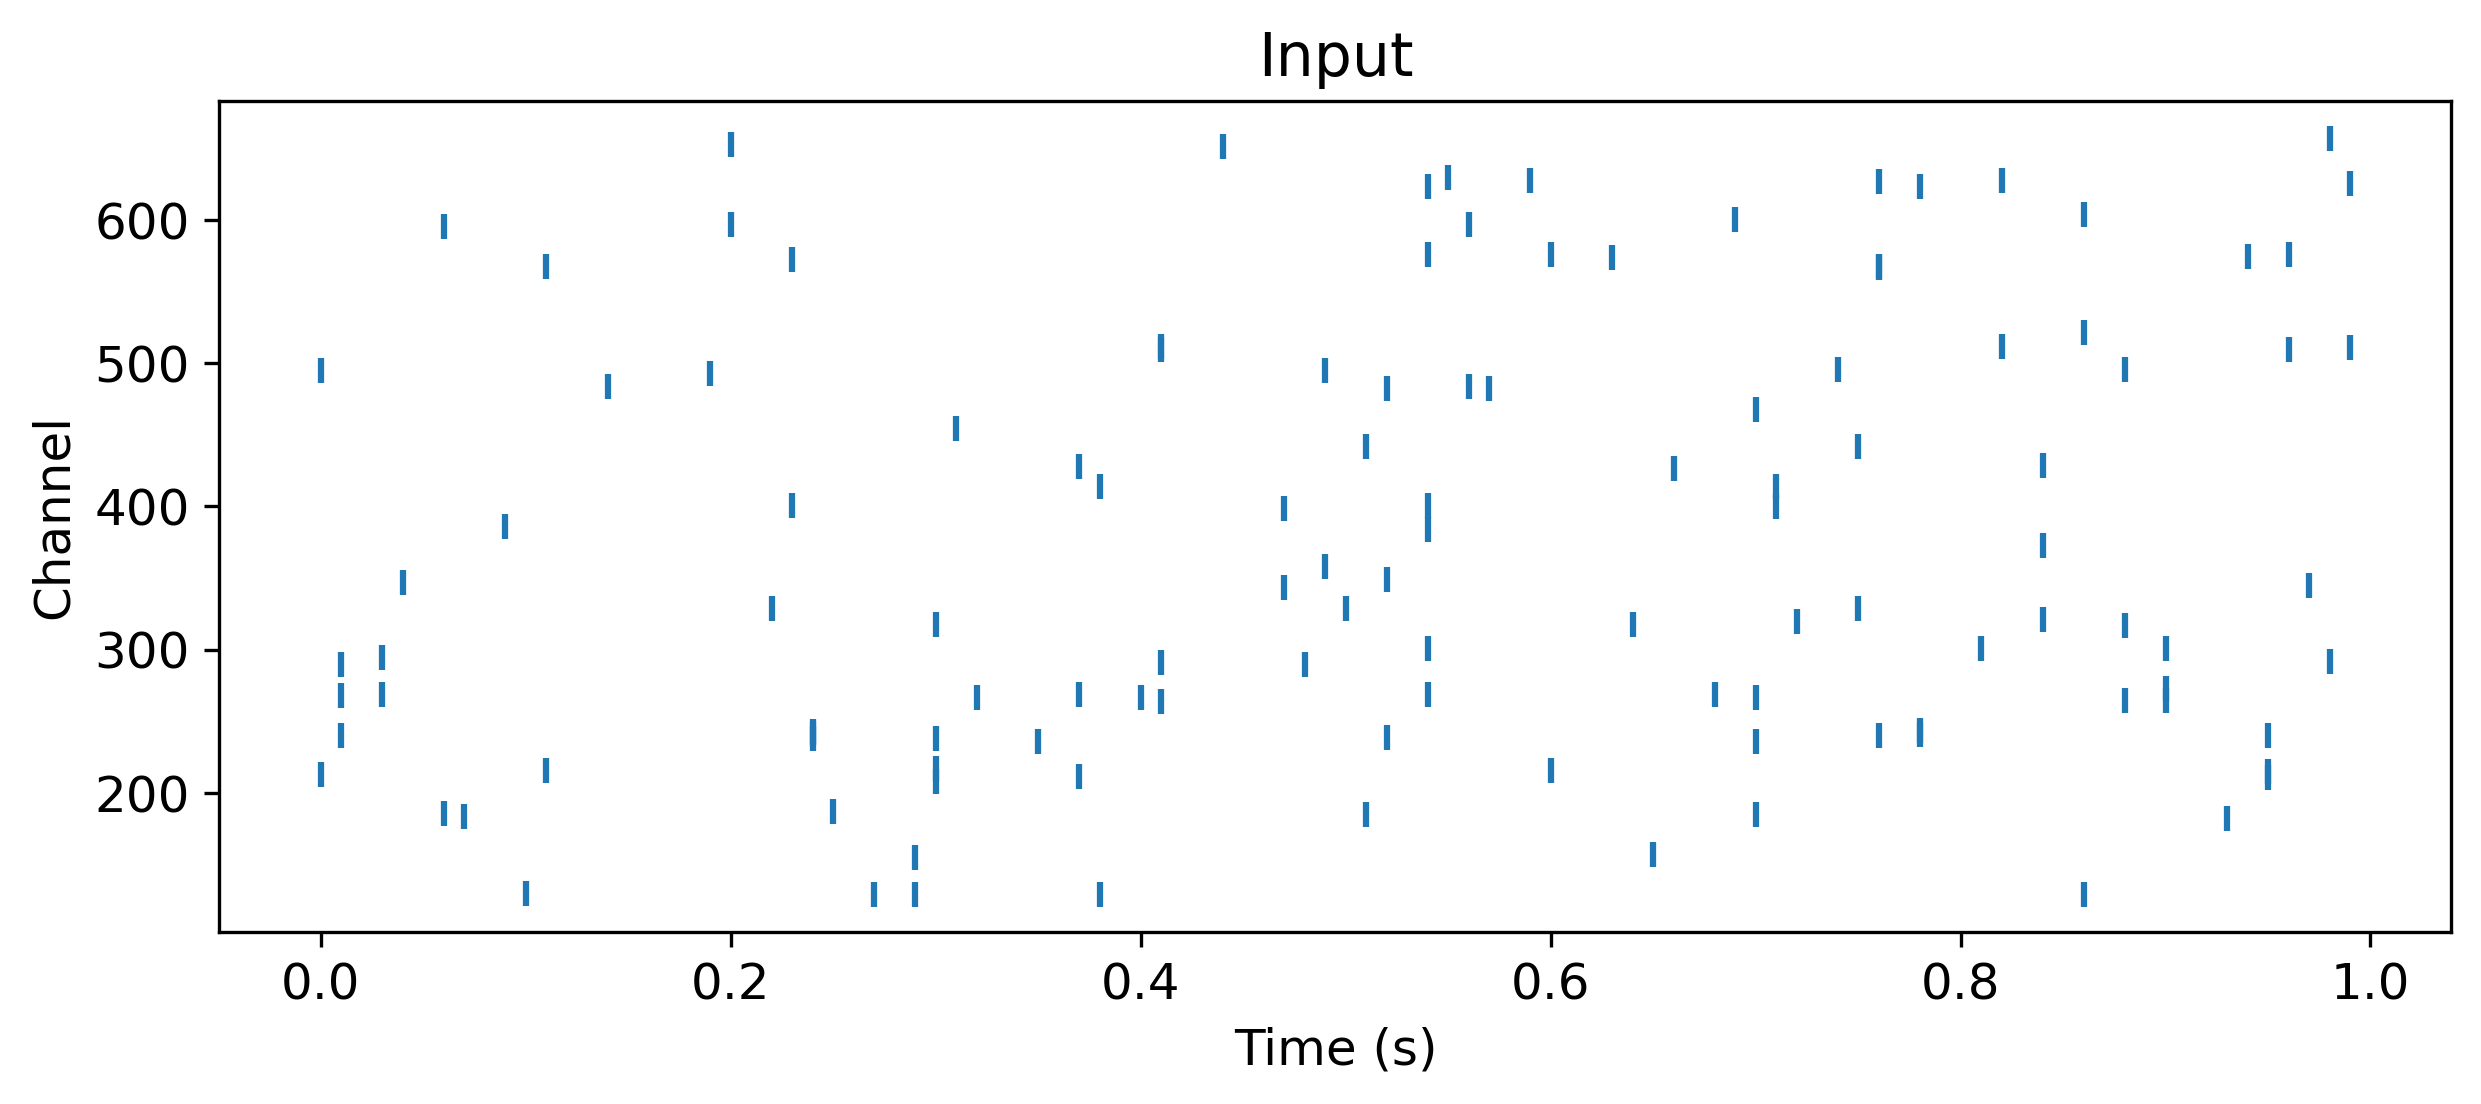

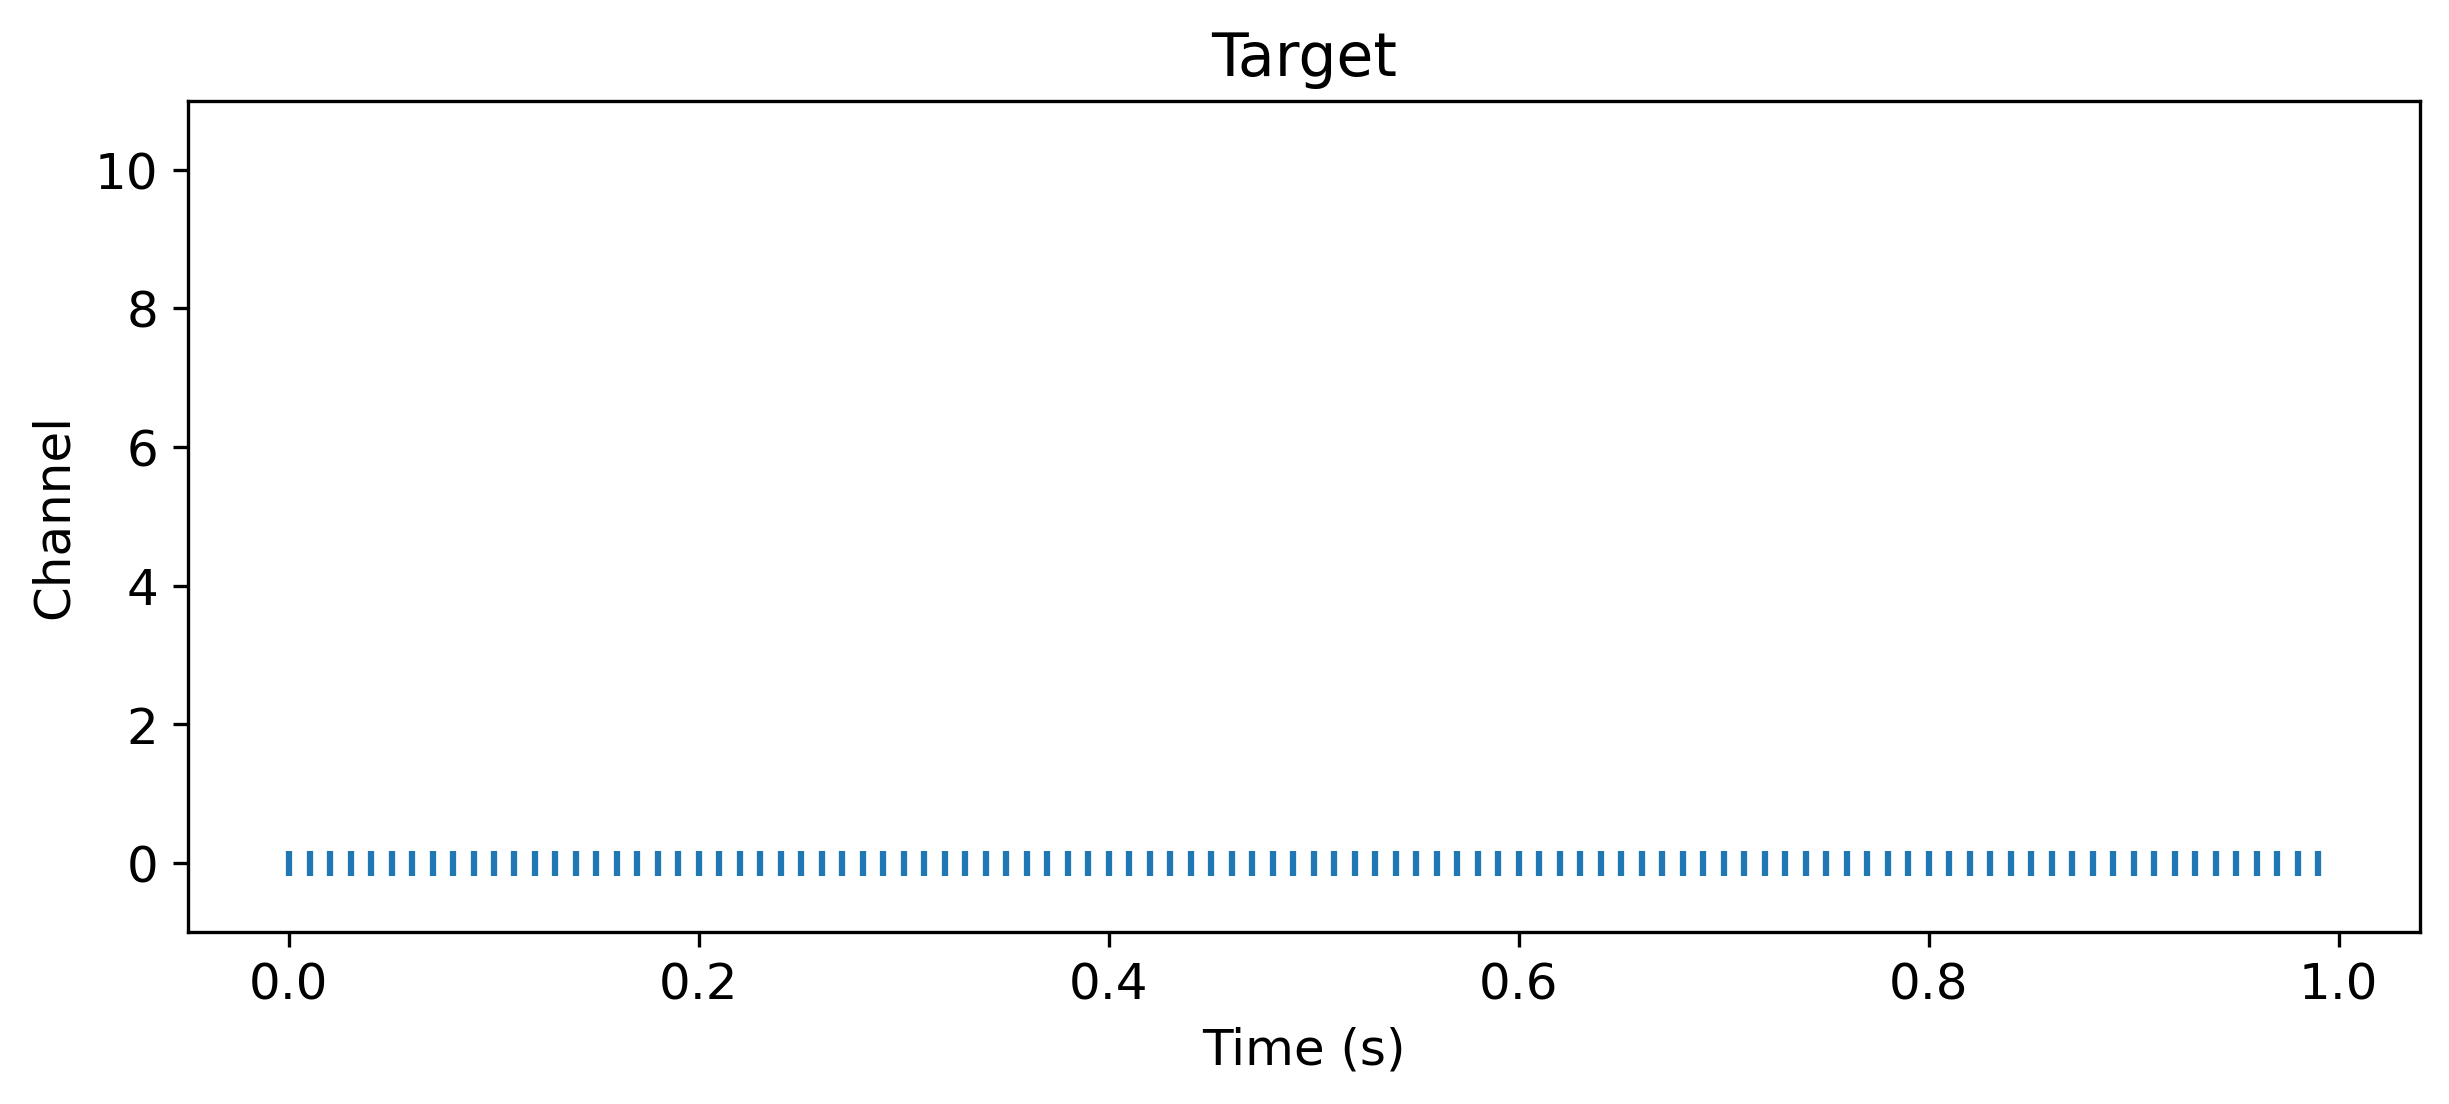

In [168]:
# - Pull a single test sample and display it
frame, class_idx = train_data[1]
data = encode_poisson(frame, num_timesteps)
target = encode_class(torch.tensor(class_idx), num_classes, num_timesteps)

plt.figure(figsize=(1, 1))
plt.imshow(frame[0])
plt.xticks([])
plt.yticks([])

plt.figure()
b, t, n = torch.nonzero(data, as_tuple = True)
plt.scatter(t * dt, n, marker='|')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Input')

b, t, n = torch.nonzero(target, as_tuple = True)
plt.figure()
plt.scatter(t * dt, n, marker='|')
plt.ylim([-1, num_classes+1])
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Target');

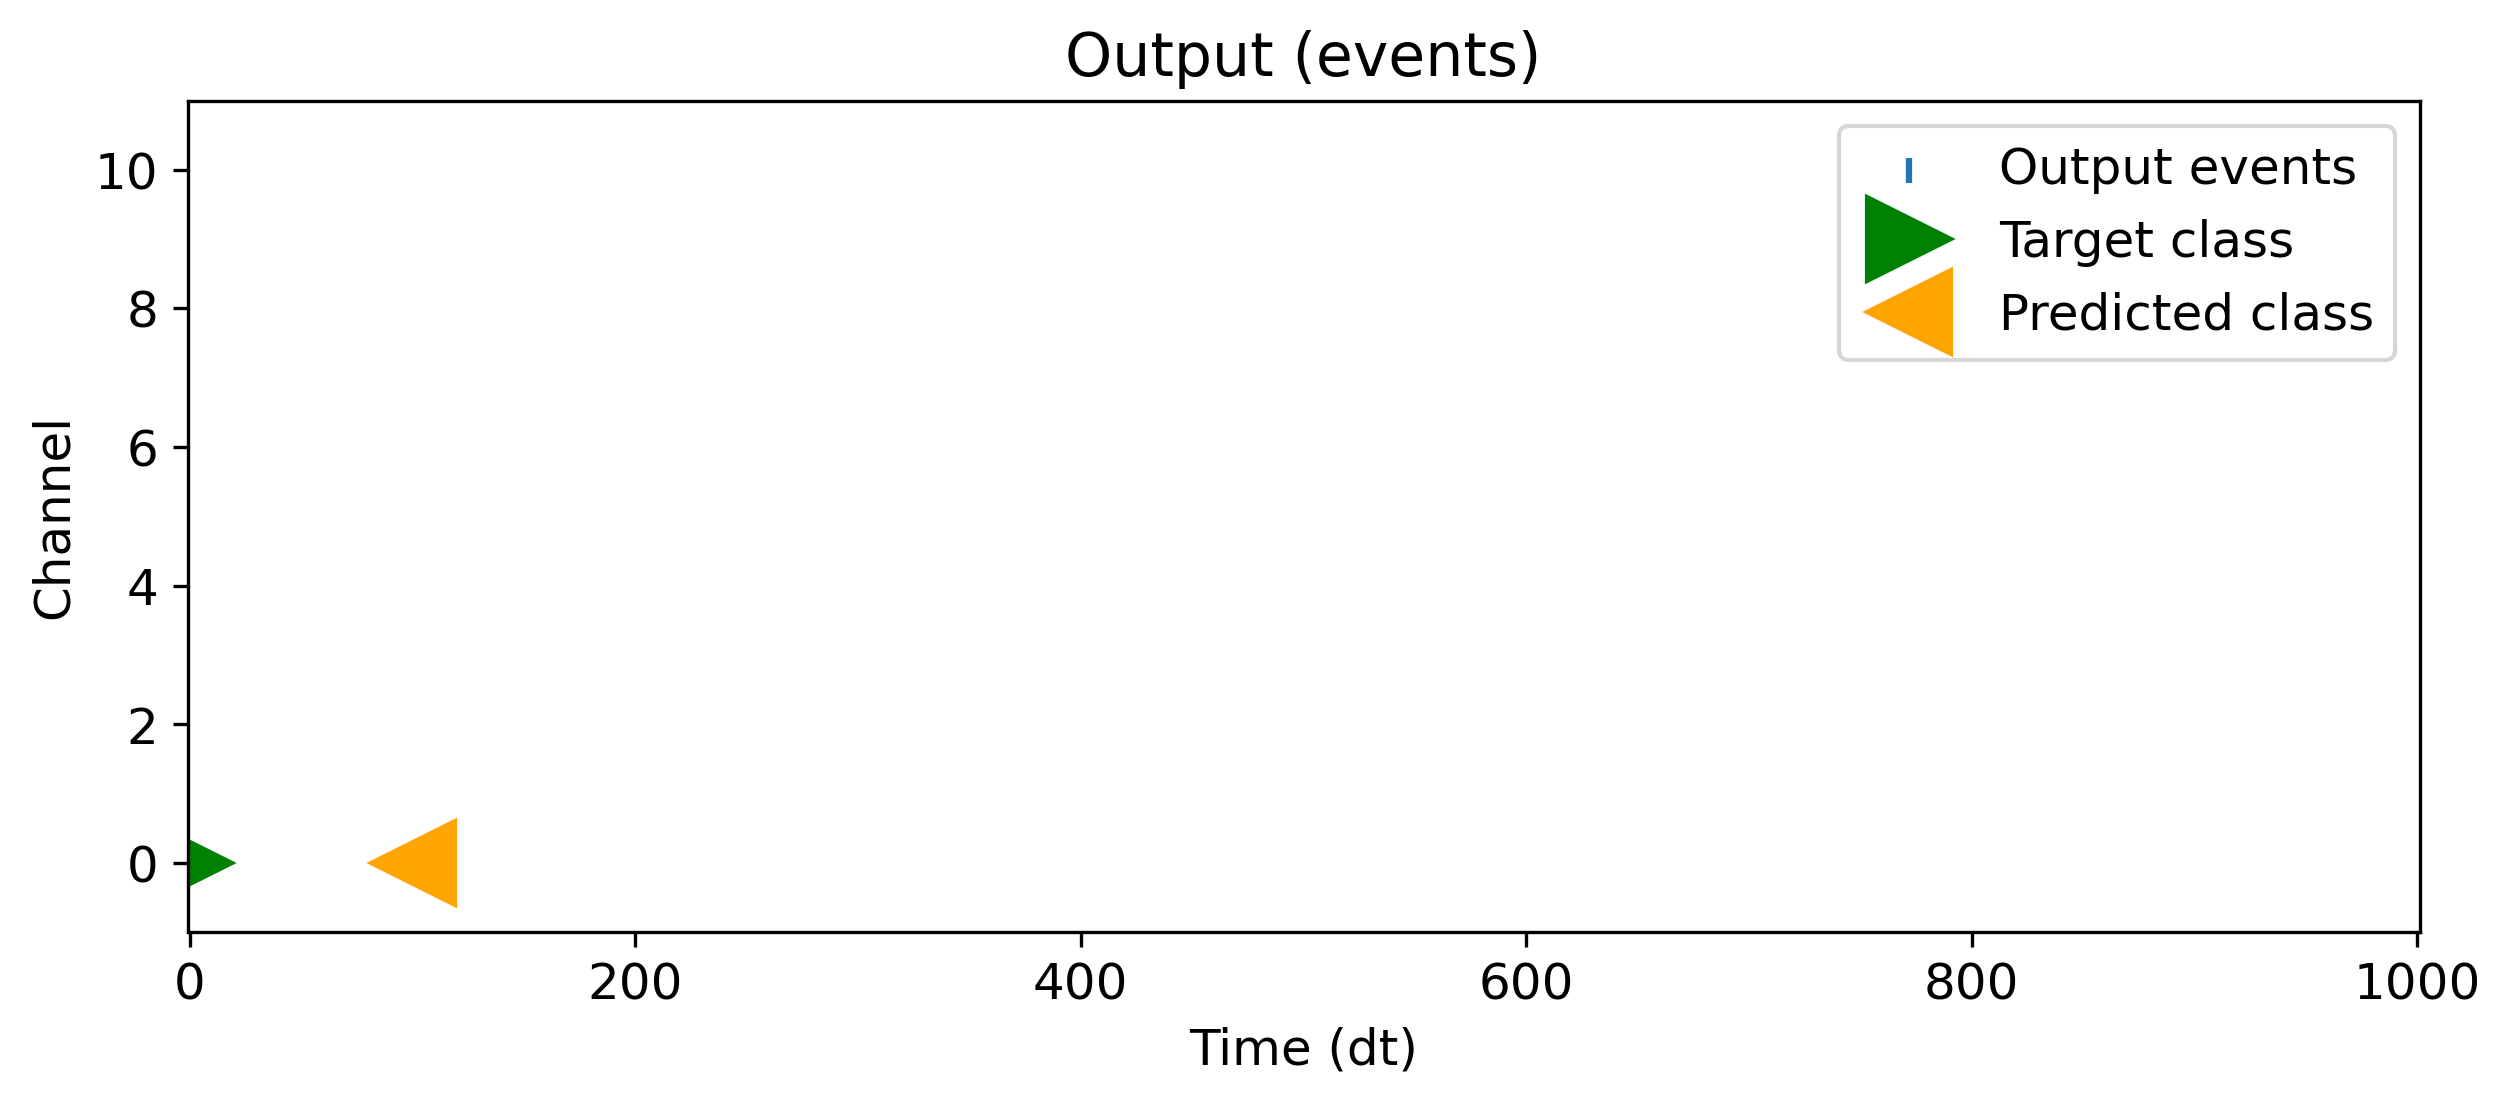

In [175]:
# - Simulate the network with this sample
output, _, _ = snn.cpu()(data)
pred = output.sum(axis = 1).argmax(axis = 1, keepdim=True).cpu()

# - Display the network output
b, t, n = torch.nonzero(output, as_tuple=True)

plt.scatter(t, n, marker='|', label='Output events')
plt.plot(0, class_idx, 'g>', markersize=20, label='Target class')
plt.plot(100, pred, '<', c='orange', markersize=20, label='Predicted class')
plt.ylim([-1, num_classes+1])
plt.xlim([-1, num_timesteps+1])
plt.xlabel('Time (dt)')
plt.ylabel('Channel')
plt.title('Output (events)')
plt.legend();



Things to consider for full trainings

- Deeper or more complex network architecture
- More hidden neurons
- Training time constants and other parameters
- Different loss function or output encoding

We will also work with the MNIST dataset to classify handwritten digits. At the end, we will compare the two approaches.


Will use the MNIST dataset in the same way as https://arxiv.org/abs/1802.06002

# Classical model

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [170]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, cnn, device):
    losses=[] # Track the loss function
    accs= [] # Track accuracies
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
    #for batch, (X, y) in tqdm(enumerate(dataloader, 0), unit="batch", total=len(dataloader)):
    #for (X,y) in tqdm(dataloader):
        X=X.to(device)
        y=y.to(device)
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        #if not cnn:
        #    X = X.reshape(X.shape[0], -1)
        print("input shape", X.shape)
        pred = model(X)
        
        #print("Y", y)
        #pred= pred.reshape([pred.shape[0], 1, num_classes])
        #print(torch.argmax(pred, dim=2), torch.argmax(y, dim=2))
        loss = loss_fn(pred,y)
        #print(loss)
        losses.append(loss.detach().cpu())
        acc = (torch.argmax(pred, 1) == y).float().mean()
        accs.append(acc.detach().cpu())
        loss.backward()
        optimizer.step()
    scheduler.step()
    return np.mean(losses), np.mean(accs)

def test_loop(dataloader, model, loss_fn, cnn, device):

    losses=[] # Track the loss function
    accs = [] # Track accuracies
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        #for batch, (X, y) in tqdm(enumerate(dataloader, 0), unit="batch", total=len(dataloader)):
        for (X,y) in tqdm(dataloader):
            X=X.to(device)
            y=y.to(device)
            pred = model(X)
            #pred= pred.reshape([pred.shape[0], 1, num_classes])
            loss = loss_fn(pred, y)
            acc = (torch.argmax(pred, 1) == y).float().mean()
            losses.append(loss.detach().cpu())
            accs.append(acc.detach().cpu())
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses), np.mean(accs)


class ConvNetwork(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(ConvNetwork, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Flatten(),
            nn.Linear(144, num_classes)
            # Another activation function here? Or not?   
            #F.log_softmax(x, dim=1)
        )
    def forward(self, x):
        x = self.conv(x)
        return x
    
in_channels = 3 # You have to figure this out
num_classes = 10 # You have to figure this out
learning_rate = 0.01 # You have to figure this out
num_epochs = 30 # You have to figure this out

# Initialize Network
model = ConvNetwork(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and Optimizer
loss_fn = torch.nn.CrossEntropyLoss() # You have to figure this out
optimizer_cnn = optim.Adam(model.parameters(), lr=learning_rate)
scheduler_cnn = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

conv_train_losses=[]
conv_test_losses=[]
conv_train_accuracies=[]
conv_test_accuracies=[]
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    conv_train_loss, conv_train_accuracy = train_loop(train_loader, model, loss_fn, optimizer_cnn, scheduler_cnn, True, device)
    conv_test_loss, conv_test_accuracy = test_loop(test_loader, model, loss_fn, True, device)
    conv_train_losses.append(conv_train_loss)
    conv_train_accuracies.append(conv_train_accuracy)
    conv_test_losses.append(conv_test_loss)
    conv_test_accuracies.append(conv_test_accuracy)
    print("Avg train loss", conv_train_loss, ", Avg test loss", conv_test_loss, ", Test accuracy", conv_test_accuracy, "Current learning rate", scheduler.get_last_lr())
print("Done!")





Epoch 1
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 2.3118966 , Avg test loss 2.2887492 , Test accuracy 0.1258789 Current learning rate [0.0005153775207320121]
Epoch 2
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 2.2599547 , Avg test loss 2.18718 , Test accuracy 0.16914062 Current learning rate [0.0005153775207320121]
Epoch 3
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 2.0248737 , Avg test loss 1.6579874 , Test accuracy 0.5293945 Current learning rate [0.0005153775207320121]
Epoch 4
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 1.4642476 , Avg test loss 1.4522505 , Test accuracy 0.5158203 Current learning rate [0.0005153775207320121]
Epoch 5
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 1.319526 , Avg test loss 1.0491645 , Test accuracy 0.6623047 Current learning rate [0.0005153775207320121]
Epoch 6
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 1.0194824 , Avg test loss 1.0144675 , Test accuracy 0.6708008 Current learning rate [0.0005153775207320121]
Epoch 7
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.76034254 , Avg test loss 0.8072292 , Test accuracy 0.7540039 Current learning rate [0.0005153775207320121]
Epoch 8
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.61607194 , Avg test loss 0.67002785 , Test accuracy 0.7866211 Current learning rate [0.0005153775207320121]
Epoch 9
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.5845433 , Avg test loss 0.568665 , Test accuracy 0.8257812 Current learning rate [0.0005153775207320121]
Epoch 10
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.43249968 , Avg test loss 0.57579833 , Test accuracy 0.8347656 Current learning rate [0.0005153775207320121]
Epoch 11
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.36941686 , Avg test loss 0.4775495 , Test accuracy 0.8607422 Current learning rate [0.0005153775207320121]
Epoch 12
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.33178446 , Avg test loss 0.41278237 , Test accuracy 0.87578124 Current learning rate [0.0005153775207320121]
Epoch 13
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.2891958 , Avg test loss 0.37055272 , Test accuracy 0.8919922 Current learning rate [0.0005153775207320121]
Epoch 14
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.24923114 , Avg test loss 0.36430898 , Test accuracy 0.8961914 Current learning rate [0.0005153775207320121]
Epoch 15
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.22680849 , Avg test loss 0.3819101 , Test accuracy 0.88974607 Current learning rate [0.0005153775207320121]
Epoch 16
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.19028948 , Avg test loss 0.34259436 , Test accuracy 0.89990234 Current learning rate [0.0005153775207320121]
Epoch 17
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.16934313 , Avg test loss 0.3339873 , Test accuracy 0.90341794 Current learning rate [0.0005153775207320121]
Epoch 18
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.15979685 , Avg test loss 0.3463625 , Test accuracy 0.8991211 Current learning rate [0.0005153775207320121]
Epoch 19
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.1355948 , Avg test loss 0.35002753 , Test accuracy 0.9006836 Current learning rate [0.0005153775207320121]
Epoch 20
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.10079218 , Avg test loss 0.33738127 , Test accuracy 0.9060547 Current learning rate [0.0005153775207320121]
Epoch 21
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.09299529 , Avg test loss 0.3014531 , Test accuracy 0.91503906 Current learning rate [0.0005153775207320121]
Epoch 22
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.06628187 , Avg test loss 0.30464536 , Test accuracy 0.9129883 Current learning rate [0.0005153775207320121]
Epoch 23
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.0714071 , Avg test loss 0.28469777 , Test accuracy 0.9213867 Current learning rate [0.0005153775207320121]
Epoch 24
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.054455515 , Avg test loss 0.31557214 , Test accuracy 0.9128906 Current learning rate [0.0005153775207320121]
Epoch 25
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.04463731 , Avg test loss 0.35136324 , Test accuracy 0.91074216 Current learning rate [0.0005153775207320121]
Epoch 26
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.042813256 , Avg test loss 0.36457443 , Test accuracy 0.90908206 Current learning rate [0.0005153775207320121]
Epoch 27
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.040809285 , Avg test loss 0.37766516 , Test accuracy 0.90595704 Current learning rate [0.0005153775207320121]
Epoch 28
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.060739964 , Avg test loss 0.36983642 , Test accuracy 0.9081055 Current learning rate [0.0005153775207320121]
Epoch 29
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.048832092 , Avg test loss 0.3812266 , Test accuracy 0.9064453 Current learning rate [0.0005153775207320121]
Epoch 30
-------------------------------
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([256, 1, 28, 28])
input shape torch.Size([88, 1, 28, 28])


  0%|          | 0/40 [00:00<?, ?it/s]

Avg train loss 0.040778477 , Avg test loss 0.358743 , Test accuracy 0.9170898 Current learning rate [0.0005153775207320121]
Done!


<Axes: >

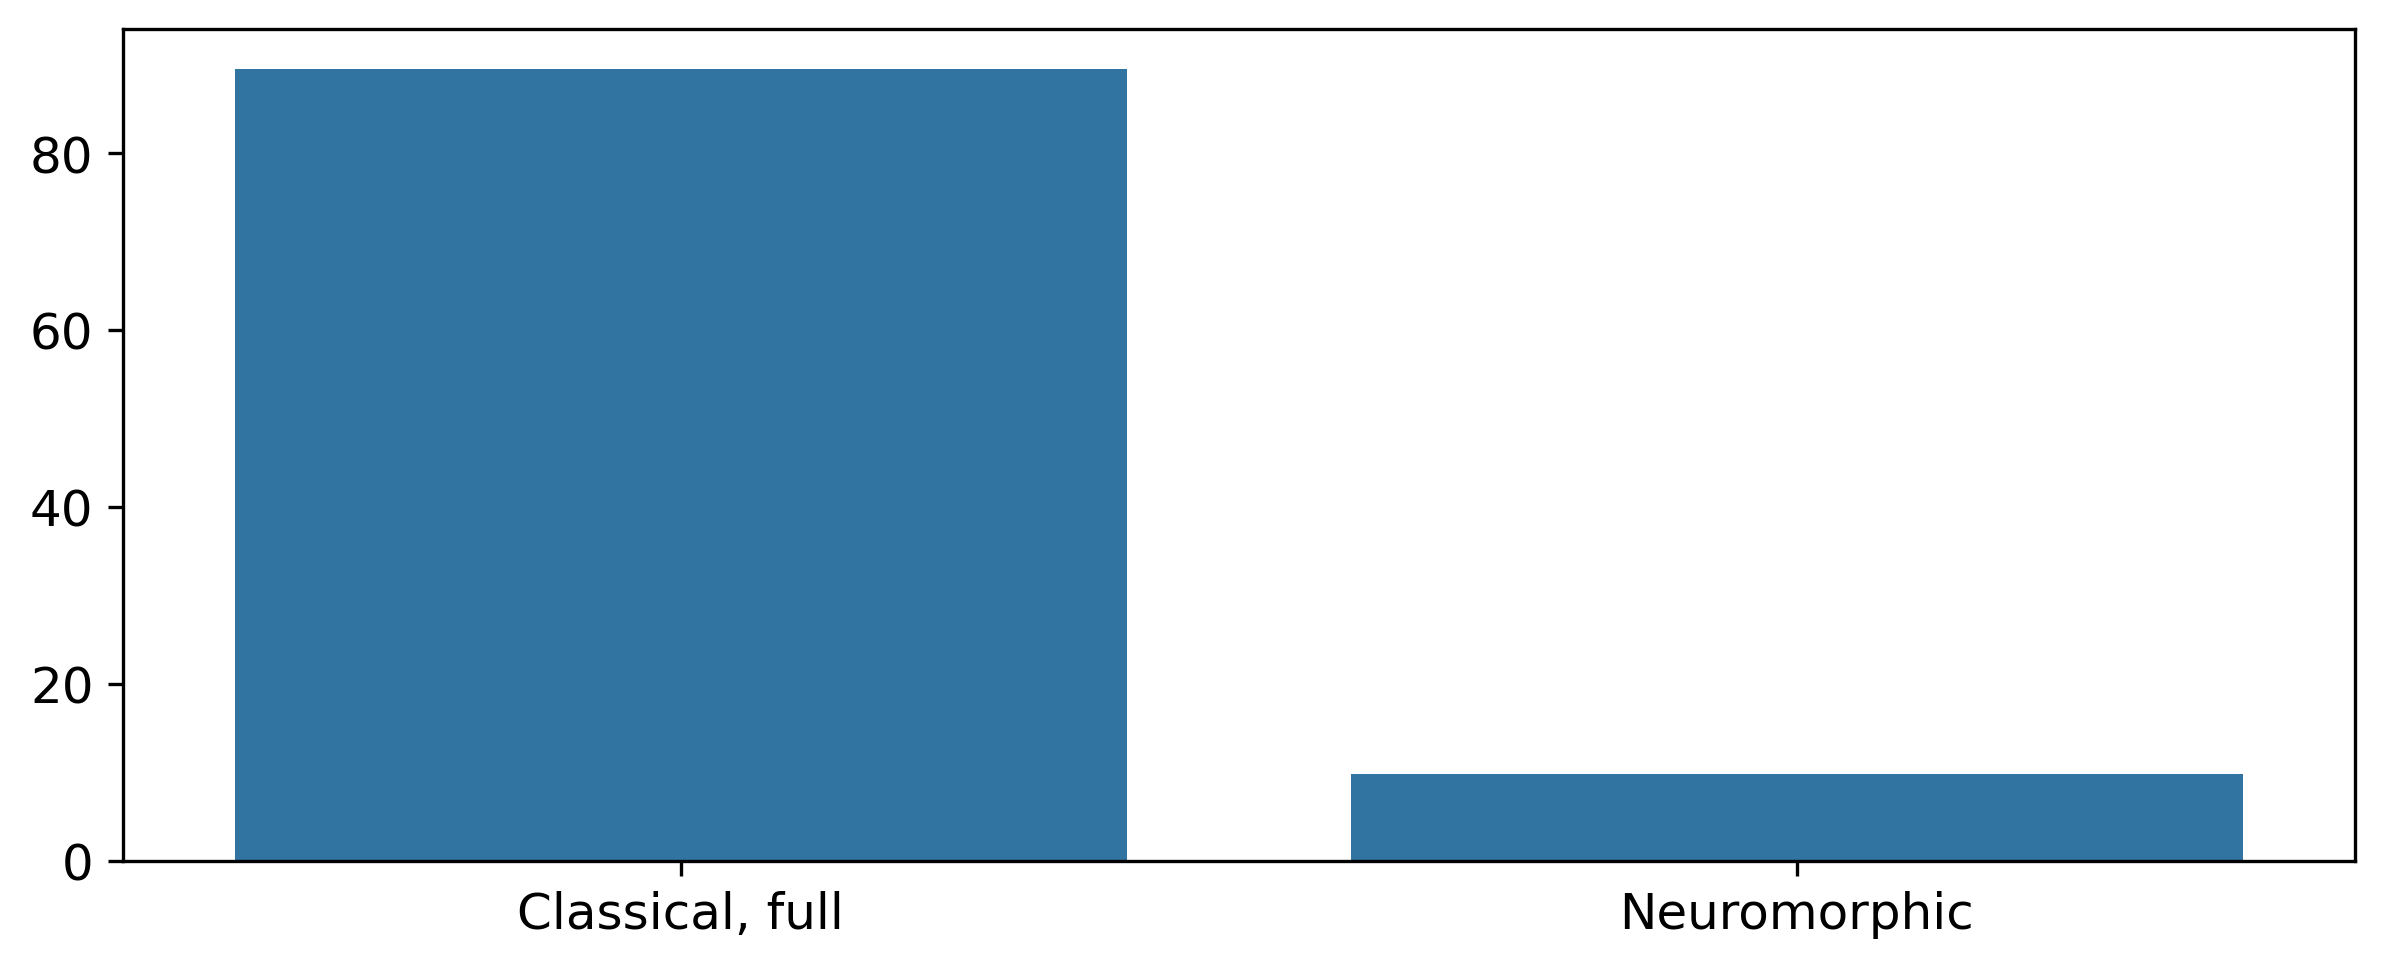

In [171]:
sns.barplot(x=["Classical, full", "Neuromorphic"],
            y=[100*cnn_accuracy[-1], neuro_accuracy])
